# Connectivity Matrix

In [1]:
# REF : 
# A mesoscale connectome of the mouse brain - Seung Wook Oh et al. (doi:10.1038/nature13186)


# Connectivity matrix != Adjacency matrix in general ...
# Because of experimental uncertainties --> values can't be 0.0 --> 
# Treshold or other tecniques in order to overcome these difficulties 
from mcmodels.core import VoxelModelCache

# Import downloaded model --> manifest_file (.json) keeps track of downloaded experiments data 
cache = VoxelModelCache(manifest_file='connectivity/voxel_model_manifest.json')
voxel_array, source_mask, target_mask = cache.get_voxel_connectivity_array()

In [2]:
#Regionalized model 
from mcmodels.models.voxel import RegionalizedModel # ALLEN INSTITUTE library 
import pandas as pd
import seaborn as sns # for graphics on networkx
from sklearn import preprocessing # to normalize the matrix 
import numpy as np 
import networkx as nx # for network analysis 
import matplotlib.pyplot as plt 
%matplotlib inline 

In [82]:
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

# The manifest file is a simple JSON file that keeps track of all of
# the data that has already been downloaded onto the hard drives.
# If you supply a relative path, it is assumed to be relative to your
# current working directory.
mcc = MouseConnectivityCache(manifest_file='connectivity/mouse_connectivity_manifest.json')

# open up a list of all of the experiments
all_experiments = mcc.get_experiments(dataframe=True)
print("%d total experiments" % len(all_experiments))

# take a look at what we know about an experiment with a primary motor injection
all_experiments.loc[122642490]

2911 total experiments


gender                                                                   M
id                                                               122642490
injection-coordinates                                   [4300, 2690, 7050]
injection-structures     [{u'abbreviation': u'MOp', u'color': u'1F9D5A'...
product-id                                                               5
strain                                                            C57BL/6J
structure-abbrev                                                       MOs
structure-color                                                     1F9D5A
structure-id                                                           993
structure-name                                        Secondary motor area
transgenic-line                                             Syt6-Cre_KI148
Name: 122642490, dtype: object

In [89]:
# grab the StructureTree instance
structure_tree = mcc.get_structure_tree()

# get info on some structures
#structures = structure_tree.get_structures_by_name(['Primary visual area', 'Hypothalamus'])
#pd.DataFrame(structures)

In [90]:
from allensdk.api.queries.ontologies_api import OntologiesApi

oapi = OntologiesApi()

# get the ids of all the structure sets in the tree
structure_set_ids = structure_tree.get_structure_sets()

# query the API for information on those structure sets
#pd.DataFrame(oapi.get_structure_sets(structure_set_ids))

In [91]:
# From the above table, "Mouse Connectivity - Summary" has id 167587189
summary_structures = structure_tree.get_structures_by_set_id([167587189])

#Structures that we are going to use for community detection check 
communities_structures = pd.DataFrame(summary_structures)

In [3]:
# Importing just the ipsilateral regionalize model 
normalized_connection_density = cache.get_normalized_connection_density()
rows_values = normalized_connection_density.index.values
columns_values = normalized_connection_density.columns.values

#ipsi_normalized_connection_density (Correlation matrix)?? right? 
ipsi_ncd = normalized_connection_density['ipsi']

In [4]:
#Matrix normalization with sklearn 
ipsi_vals = ipsi_ncd.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
ipsi_vals_scaled = min_max_scaler.fit_transform(ipsi_vals)
ipsi_ncd = pd.DataFrame(ipsi_vals_scaled)

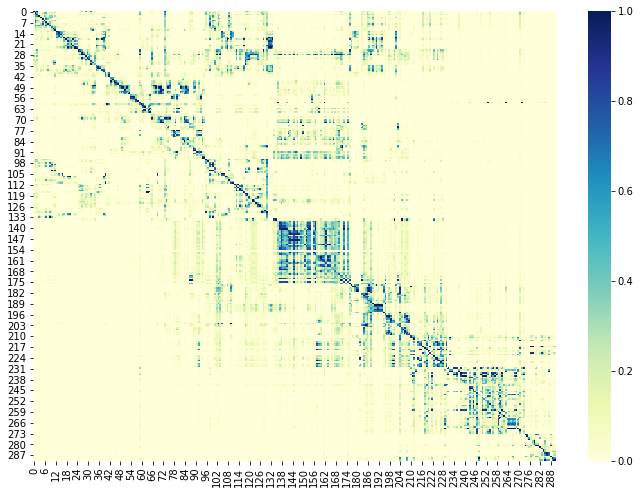

In [5]:
#ipsi_ncd heatmap --> look at the paper omg !! C'est le meme
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.heatmap(ax = ax, data = ipsi_ncd, cmap="YlGnBu")

# Rows and columns are ordered to emphasize modular structure. Regions belonging to the same topological module 
# are clustered together along the diagonal, giving a block-diagonal structure to the matrix.
# Modules are delineated by white lines. Connectivity within each module is strong and relatively weak between modules.


In [6]:
# It's not an adjacency matrix but a connectivity one, we can try to build a net based on that 
# one and seeee what happens 

# Dropping self connectivity 
np.fill_diagonal(ipsi_ncd.values, 0.0)


In [7]:
# Networkx graph ipsilateral 
ipsi_ncd_matrix = ipsi_ncd.values
graph_ipsi = nx.convert_matrix.from_numpy_matrix(ipsi_ncd_matrix , create_using= nx.DiGraph() )

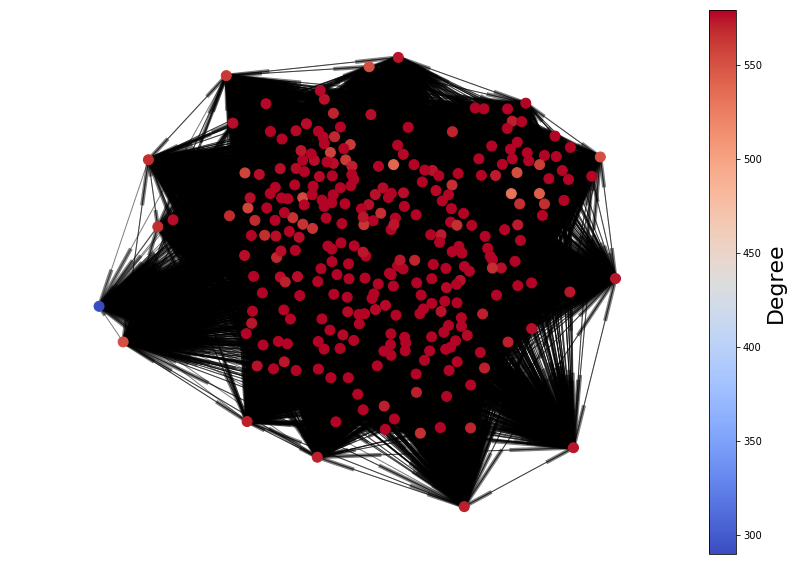

In [8]:
# Plotting degree based colormap 
plt.figure(figsize=(14,10))
pos= nx.spring_layout(graph_ipsi, k = 0.4)

s=nx.draw_networkx_nodes(graph_ipsi,
            pos,
            node_size=100.0,
            node_color=list(dict(nx.degree(graph_ipsi)).values()),
            alpha=1,
            cmap=plt.cm.coolwarm
            )

nx.draw_networkx_edges(graph_ipsi, pos, alpha=0.5)

#show the colorbar on the right side
cbar=plt.colorbar(s)
cbar.ax.set_ylabel('Degree', size=22)

plt.axis('off')
plt.show()

In [9]:
# Connectivity and clustering --> too many edges
print "The graph has", len(graph_ipsi), "nodes and",len(graph_ipsi.edges()),"edges"

The graph has 291 nodes and 83631 edges


# Adjacency Matrix - Using treshold 20% 

In [10]:
#Setting treshold 
ipsi_ncd_tresh = ipsi_ncd.where(ipsi_ncd > 0.2 , 0.0)

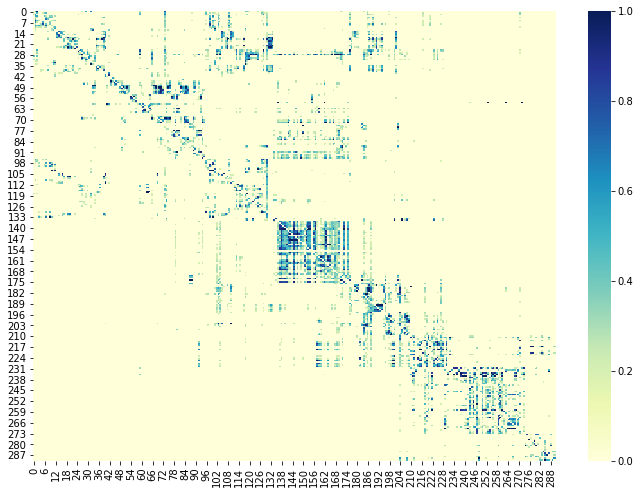

In [11]:
#ipsi_ncd heatmap --> look at the paper omg !! C'est le meme
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.heatmap(ax = ax, data = ipsi_ncd_tresh, cmap="YlGnBu")

In [12]:
# Networkx graph ipsilateral 
ipsi_ncd_tresh = ipsi_ncd_tresh.values
graph_ipsi_tresh = nx.convert_matrix.from_numpy_matrix(ipsi_ncd_tresh, create_using= nx.DiGraph())

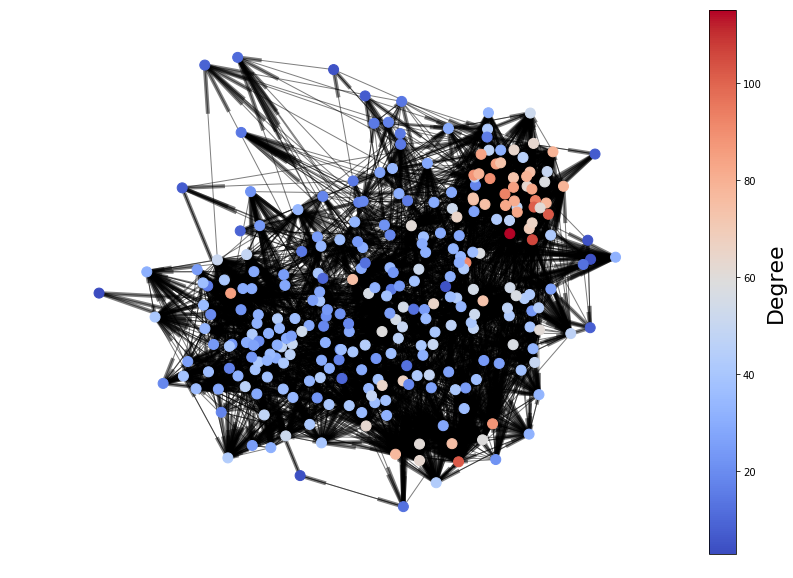

In [13]:
# Plotting network with colormap based on degree 
plt.figure(figsize=(14,10))
pos= nx.spring_layout(graph_ipsi_tresh, k = 0.4)

s=nx.draw_networkx_nodes(graph_ipsi_tresh,
            pos,
            node_size=100.0,
            node_color=list(dict(nx.degree(graph_ipsi_tresh)).values()),
            alpha=1,
            cmap=plt.cm.coolwarm
            )

nx.draw_networkx_edges(graph_ipsi_tresh, pos, alpha=0.5)

#show the colorbar on the right side
cbar=plt.colorbar(s)
cbar.ax.set_ylabel('Degree', size=22)

plt.axis('off')
plt.show()

stdev for data is 0.345206585129
mean of data is 37.2242336626


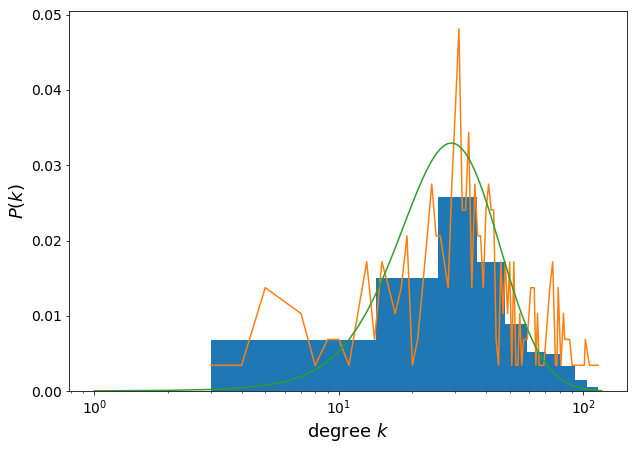

In [160]:
#degree distribution 
from scipy.optimize import curve_fit
from scipy.misc import factorial
from collections import Counter
from scipy.stats import lognorm
from scipy.stats import norm

# dict with degree.values()
deg=dict(graph_ipsi_tresh.degree()).values()
deg_distri=Counter(deg)

x=[]
y=[]
for i in sorted(deg_distri):   
    x.append(i)
    y.append(float(deg_distri[i]) /float(len(graph_ipsi_tresh)))


#y = [np.log10 for i in y]

plt.figure(figsize=(10,7))    

plt.xlabel('degree $k$', fontsize=18)
plt.ylabel('$P(k)$', fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
entries, bin_edges, patches = plt.hist(deg  , normed = True ,histtype='stepfilled')
bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])

#-------------------
# http://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0035029&type=printable
# Statistics of Weighted Brain Networks Reveal Hierarchical Organization and Gaussian Degree Distribution 

# Lognormal distribution fitting 
scatter,loc,mean = lognorm.fit(x ,floc=0)   
x_fit = np.linspace(min(bin_middles), max(bin_middles) , num = 120 )

scatter = scatter -0.45

pdf_fitted = lognorm.pdf(x_fit ,scatter,loc,mean) #Gives the PDF
print "stdev for data is %s" %scatter
print "mean of data is %s" %mean 
#-------------------
#Normal distribution 
#norm_pdf = stats.norm.pdf(bin_middles)

#-------------------



#y_new = [i + 1 for i in y] 
plt.plot(x, y , pdf_fitted)



#plt.yscale('log')
plt.xscale('log')
#plt.axis([1,1000,0.00001,0.2])
plt.show()

### Connectivity and small-worldness test 



In [15]:
print "The graph has", len(graph_ipsi_tresh), "nodes and",len(graph_ipsi_tresh.edges()),"edges"

The graph has 291 nodes and 5798 edges


In [16]:
# Average shortest path length 
avg_short_path_length = nx.average_shortest_path_length(graph_ipsi_tresh)
print "The graph has", '%.2f' % avg_short_path_length ,"average shortest path length"

The graph has 3.23 average shortest path length


In [17]:
#Average degree connectivity 
degree_conn = nx.average_degree_connectivity(graph_ipsi_tresh)
avg_degree_conn =  np.average(degree_conn.values())
print "The graph has", '%.2f' % avg_degree_conn ,"average degree connectivity"

The graph has 25.86 average degree connectivity


In [20]:
# Network small-worldness has been quantified by a small-coefficient, 
# σ (>1 in small world) , calculated by comparing clustering and path length of a given 
# network to an equivalent random network with same degree on average

#First create  a ER network , we need p and N --> N = 291 like our net 
# In ER nets <k> = p (N-1) #<k> avg degree, p connection probability, N number of nodes 
number_of_nodes = 291 
p_ER_net = avg_degree_conn /  (number_of_nodes -1 ) 

random_net = nx.erdos_renyi_graph(number_of_nodes,p_ER_net)
clust_coeff = nx.average_clustering(nx.Graph.to_undirected(graph_ipsi_tresh))
random_clust_coeff = nx.average_clustering(random_net)
random_avg_short_path_length = nx.average_shortest_path_length(random_net)

sigma = (avg_short_path_length/random_avg_short_path_length) / (clust_coeff/random_clust_coeff)

print  "The graph has σ =", '%.2f' % sigma ,"small-worldness coefficient"
print "The network isn't small world"

The graph has σ = 0.26 small-worldness coefficient
The network isn't small world


# Centrality 

In [21]:
# This definition of centrality assumes that nodes with many connections exert more 
# influence over network function and thus have higher topological centrality compared 
# to nodes with fewer connections.
centrality = nx.degree_centrality(graph_ipsi_tresh)
# One limitation of degree centrality is that all connections are treated equally.


# Eigenvector centrality is a measure that accounts for the quantity and quality of a node’s connections. 
# It considers both the degree of that node and the degree of its neighbors.
eigen_centrality = nx.eigenvector_centrality(graph_ipsi_tresh)

#  This usage implies a sense of closeness: we can think of two nodes being maximally close in a topological 
# sense if they share a direct connection whereas two nodes that are only linked indirectly through 
# many intermediate nodes are topologically distant.
clos_centrality = nx.closeness_centrality(graph_ipsi_tresh)

#Betweeness centrality It measures the proportion of shortest paths between all node pairs 
# in the network that pass through a given index node.
betw_centrality = nx.betweenness_centrality(graph_ipsi_tresh)

(array([ 1.95753559,  4.35996564,  7.4742268 ,  4.98281787,  2.58038783,
         1.51264114,  1.42366225,  0.9787678 ,  0.44489445,  0.17795778]),
 array([ 0.01034483,  0.04896552,  0.08758621,  0.1262069 ,  0.16482759,
         0.20344828,  0.24206897,  0.28068966,  0.31931034,  0.35793103,
         0.39655172]),
 <a list of 1 Patch objects>)

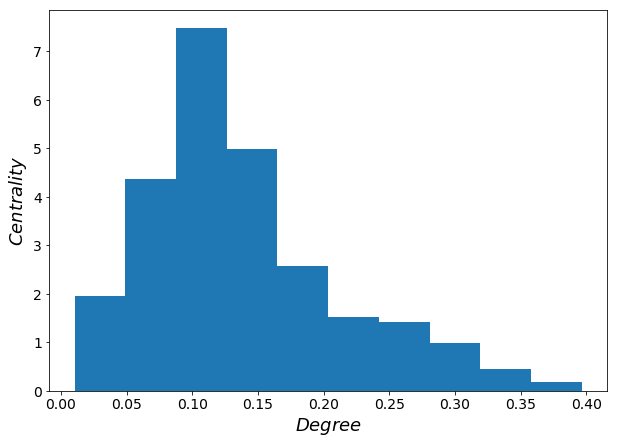

In [22]:
# Degree Centrality 
plt.figure(figsize=(10,7))    

plt.xlabel('$Degree$', fontsize=18)
plt.ylabel( '$Centrality$' , fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.hist( centrality.values() , normed = True ,histtype='stepfilled')

(array([ 42.22796185,   1.41942729,   0.88714206,   0.35485682,
          0.17742841,   0.88714206,   0.88714206,   0.53228523,
          1.95171252,   2.30656934]),
 array([  3.21269630e-08,   1.93679907e-02,   3.87359493e-02,
          5.81039079e-02,   7.74718664e-02,   9.68398250e-02,
          1.16207784e-01,   1.35575742e-01,   1.54943701e-01,
          1.74311659e-01,   1.93679618e-01]),
 <a list of 1 Patch objects>)

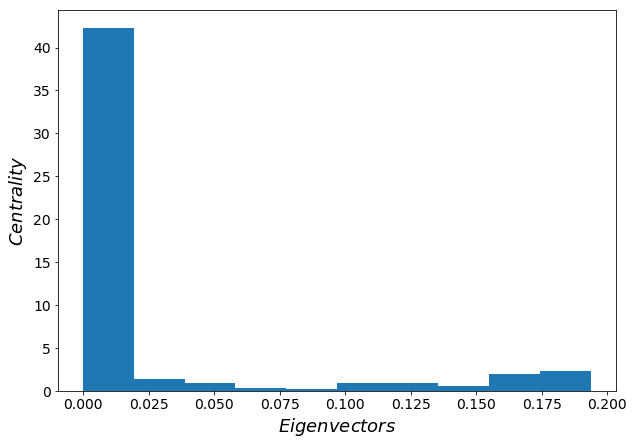

In [23]:
#Eigenvalues centrality 
plt.figure(figsize=(10,7))    

plt.xlabel('$Eigenvectors$', fontsize=18)
plt.ylabel( '$Centrality$' , fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.hist( eigen_centrality.values() , normed = True ,histtype='stepfilled')

(array([ 0.85959011,  3.62938046,  4.67999059,  4.29795054,  4.10693052,
         3.43836043,  3.91591049,  1.43265018,  1.05061013,  0.38204005]),
 array([ 0.16716177,  0.20314152,  0.23912127,  0.27510102,  0.31108076,
         0.34706051,  0.38304026,  0.41902001,  0.45499975,  0.4909795 ,
         0.52695925]),
 <a list of 1 Patch objects>)

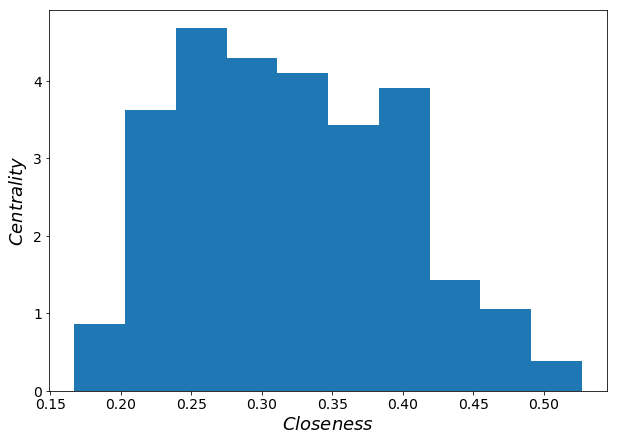

In [24]:
# Closeness centrality 
plt.figure(figsize=(10,7))    

plt.xlabel('$Closeness$', fontsize=18)
plt.ylabel( '$Centrality$' , fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.hist( clos_centrality.values() , normed = True ,histtype='stepfilled')

(array([ 106.56735785,   27.35418811,   14.81685189,    4.55903135,
           3.41927351,    2.27951568,    2.84939459,    1.13975784,
           1.13975784,    1.70963676]),
 array([ 0.        ,  0.0060301 ,  0.0120602 ,  0.0180903 ,  0.02412039,
         0.03015049,  0.03618059,  0.04221069,  0.04824079,  0.05427089,
         0.06030099]),
 <a list of 1 Patch objects>)

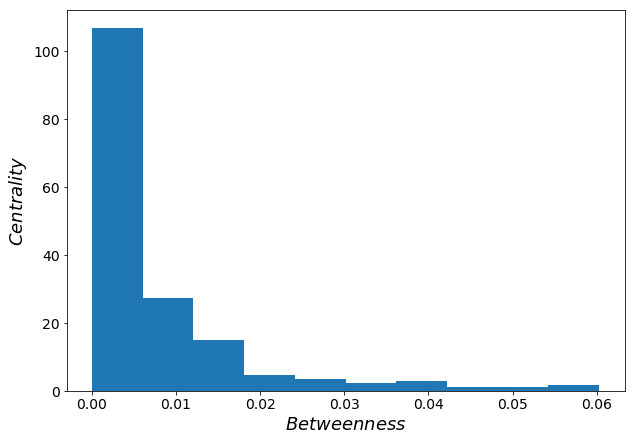

In [25]:
#Betweenness  centrality 
plt.figure(figsize=(10,7))    

plt.xlabel('$Betweenness$', fontsize=18)
plt.ylabel( '$Centrality$' , fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.hist( betw_centrality.values() , normed = True ,histtype='stepfilled')

# PageRank and Hits Hubs 

In [26]:
import operator
#Pagerank 
PR_graph = nx.pagerank_scipy(graph_ipsi_tresh)
max_PR = max(PR_graph.values())
PR_graph_inv = dict((v,k) for k, v in PR_graph.iteritems())
#PR_graph_inv[max_PR]
largest_PR = dict(sorted(PR_graph.iteritems(), key= operator.itemgetter(1), reverse=True)[: 10])
PR_region_name = []
for i in largest_PR.keys() :
    PR_region_name.append(normalized_connection_density['ipsi'].columns[i])

In [154]:
# Getting features of PR regions 
for i in xrange(0,len(PR_region_name)):
    for j in  xrange(0, len(communities_structures.iloc[0: , 0])): 
        
        if PR_region_name[i] == communities_structures.iloc[0: , 0][j] : 
            row_index = communities_structures.loc[communities_structures['acronym']== communities_structures.iloc[0: , 0][j]  ].index[0]
            print  communities_structures.iloc[row_index, 0:]

acronym                                                             RT
graph_id                                                             1
graph_order                                                        703
id                                                                 262
name                                 Reticular nucleus of the thalamus
rgb_triplet                                            [255, 144, 159]
structure_id_path                   [997, 8, 343, 1129, 549, 856, 262]
structure_set_ids    [112905828, 10, 12, 184527634, 167587189, 1145...
Name: 76, dtype: object
acronym                                                             RN
graph_id                                                             1
graph_order                                                        853
id                                                                 214
name                                                       Red nucleus
rgb_triplet                                          

In [28]:
# Hits Hubs

hits_hubs = nx.hits_scipy(graph_ipsi_tresh)
hubs_dict = hits_hubs[0]
max_val = max(hubs_dict.values())
hubs_dict_inv = dict((v,k) for k, v in hubs_dict.iteritems())
hubs_dict_inv[max_val]
 
#largest_hubs --> n values --> 10 in this case 
largest_hubs = dict(sorted(hubs_dict.iteritems(), key= operator.itemgetter(1), reverse=True)[: 10])
hubs_region_name = []
for i in largest_hubs.keys() :
    hubs_region_name.append(normalized_connection_density['ipsi'].columns[i])

In [155]:
# Getting description of Hubs regions 
for i in xrange(0,len(hubs_region_name)):
    for j in  xrange(0, len(communities_structures.iloc[0: , 0])): 
        
        if hubs_region_name[i] == communities_structures.iloc[0: , 0][j] : 
            row_index = communities_structures.loc[communities_structures['acronym']== communities_structures.iloc[0: , 0][j]  ].index[0]
            print  communities_structures.iloc[row_index, 0:]

acronym                                                            VMH
graph_id                                                             1
graph_order                                                        787
id                                                                 693
name                                 Ventromedial hypothalamic nucleus
rgb_triplet                                              [255, 76, 62]
structure_id_path                  [997, 8, 343, 1129, 1097, 467, 693]
structure_set_ids    [112905828, 10, 12, 184527634, 167587189, 1145...
Name: 177, dtype: object
acronym                                                            PVa
graph_id                                                             1
graph_order                                                        731
id                                                                  30
name                 Periventricular hypothalamic nucleus, anterior...
rgb_triplet                                         

In [30]:
# Export file in gephi extension --> gephi is a software for dynamical modeling of nets 
# In a few lines of code I'll import the net made with gephi 
# nx.write_gexf(graph_ipsi_tresh, "graph_ipsi.gexf")

In [185]:
# node with max degree 
max_degree = max(dict(nx.degree(graph_ipsi_tresh)).values())
max_number = [key for key, value in dict(nx.degree(graph_ipsi_tresh)).iteritems() if value == max_degree ][0]
print "The node with highest degree is", max_number , "with degree",max_degree

The node with highest degree is 169 with degree 115


In [156]:
# Create a dict in order to see the degree of the main hubs 
# Why the highest degree node isn't a hub ? Bc it doesn't communicate with many regions? 
hubs_degree  = []
for i in largest_hubs.keys(): 
    hubs_degree.append(graph_ipsi_tresh.degree[i])

hubs_keys = largest_hubs.keys()

def create_dict(keys, values):
    return dict(zip(keys, values ))

hubs_dict = create_dict(hubs_keys, hubs_degree)
sorted_hubs_dict = sorted(hubs_dict.items(), key=operator.itemgetter(1), reverse=True)
sorted_hubs_dict

[(28, 91),
 (175, 85),
 (154, 78),
 (139, 75),
 (141, 75),
 (152, 73),
 (146, 64),
 (167, 61),
 (144, 50),
 (148, 45)]

In [158]:
# Create a dict in order to see the degree of the largest PRs
PR_degree  = []
for i in largest_PR.keys(): 
    PR_degree.append(graph_ipsi_tresh.degree[i])

PR_keys = largest_PR.keys()

PR_dict = create_dict(PR_keys, PR_degree)
sorted_PR_dict = sorted(PR_dict.items(), key=operator.itemgetter(1), reverse=True)
sorted_PR_dict

[(138, 102),
 (188, 102),
 (145, 90),
 (184, 88),
 (157, 88),
 (130, 85),
 (186, 77),
 (204, 75),
 (196, 43),
 (207, 32)]

# Community detection 

In [33]:
#Let's make a dict with key = node number, value = 'string' of the corresponding structure 
struct_names = []
struct_number = [] 
for i in xrange(0, len(normalized_connection_density['ipsi'].columns)) :
    struct_names.append(normalized_connection_density['ipsi'].columns[i])
    struct_number.append(i)

struct_dict = create_dict(struct_number, struct_names)

In [34]:
# HowTo --> https://perso.crans.org/~aynaud/communities/
#Using community lib to study partitions --> trying to infer brain regions from communities detection 
import community
dendrogram = community.generate_dendrogram(nx.Graph.to_undirected(graph_ipsi_tresh))
level = 1
communities_dict = community.partition_at_level(dendrogram, level)
#print "partition at level", level, "is", communities_dict 

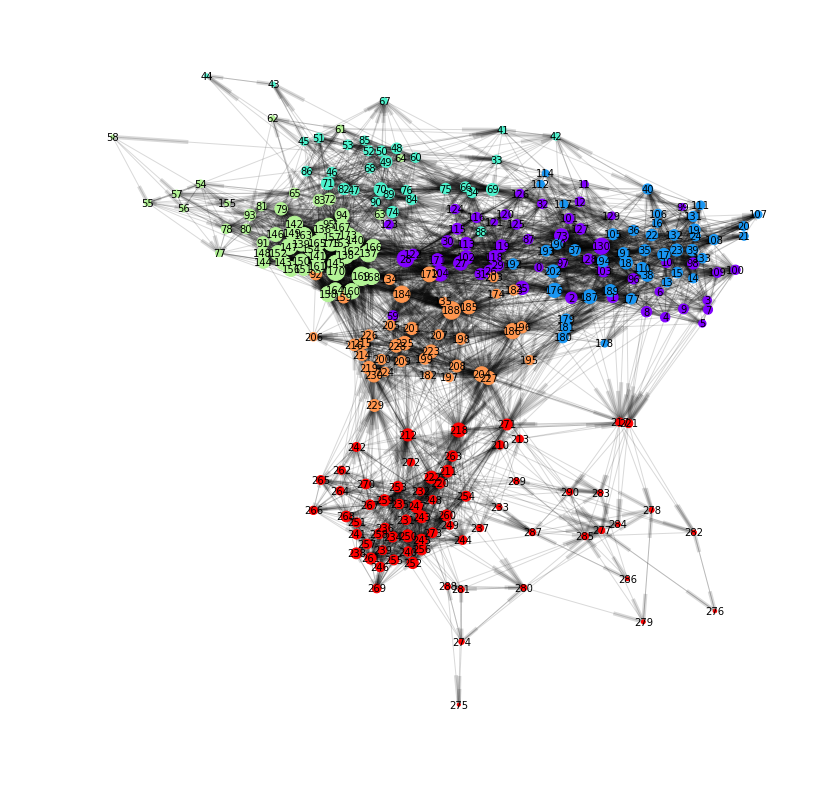

In [35]:
# Tutorial 
# http://ryancompton.net/2014/06/16/community-detection-and-colored-plotting-in-networkx/


#Atlas regions 
# http://atlas.brain-map.org/atlas?atlas=1#atlas=1&plate=100960221&structure=528&x=5279.75&y=3743.75&zoom=-3&resolution=16.75&z=5
graph_ipsi_directed = nx.Graph.to_undirected(graph_ipsi_tresh)
part = community.best_partition(graph_ipsi_directed)

# Values in order to get different colors for communities 
values = [part.get(node) for node in graph_ipsi_tresh.nodes()]


plt.figure(figsize=(14,14))
pos= nx.spring_layout(graph_ipsi_directed, iterations = 1000, k = 0.4 )

#Getting degree in order to plot nodes with size proportional to degree 
d = nx.degree(graph_ipsi_tresh)

nx.draw_networkx_nodes(graph_ipsi_tresh, pos,
            node_size= [d[v] * 3 for v in range(len(d))] ,
            node_color = values,
            alpha=1,
            cmap = plt.get_cmap('rainbow')
             )
nx.draw_networkx_edges(graph_ipsi_tresh,  pos,  alpha=0.15)

nx.draw_networkx_labels(graph_ipsi_tresh, pos, font_size = 10)
plt.axis('off')
plt.show()

In [36]:
modularity = community.modularity(part,graph_ipsi_directed)
print "modularity:", '%.2f' % modularity
# 0.55 is high -->  -1< modularity < 1 

modularity: 0.55


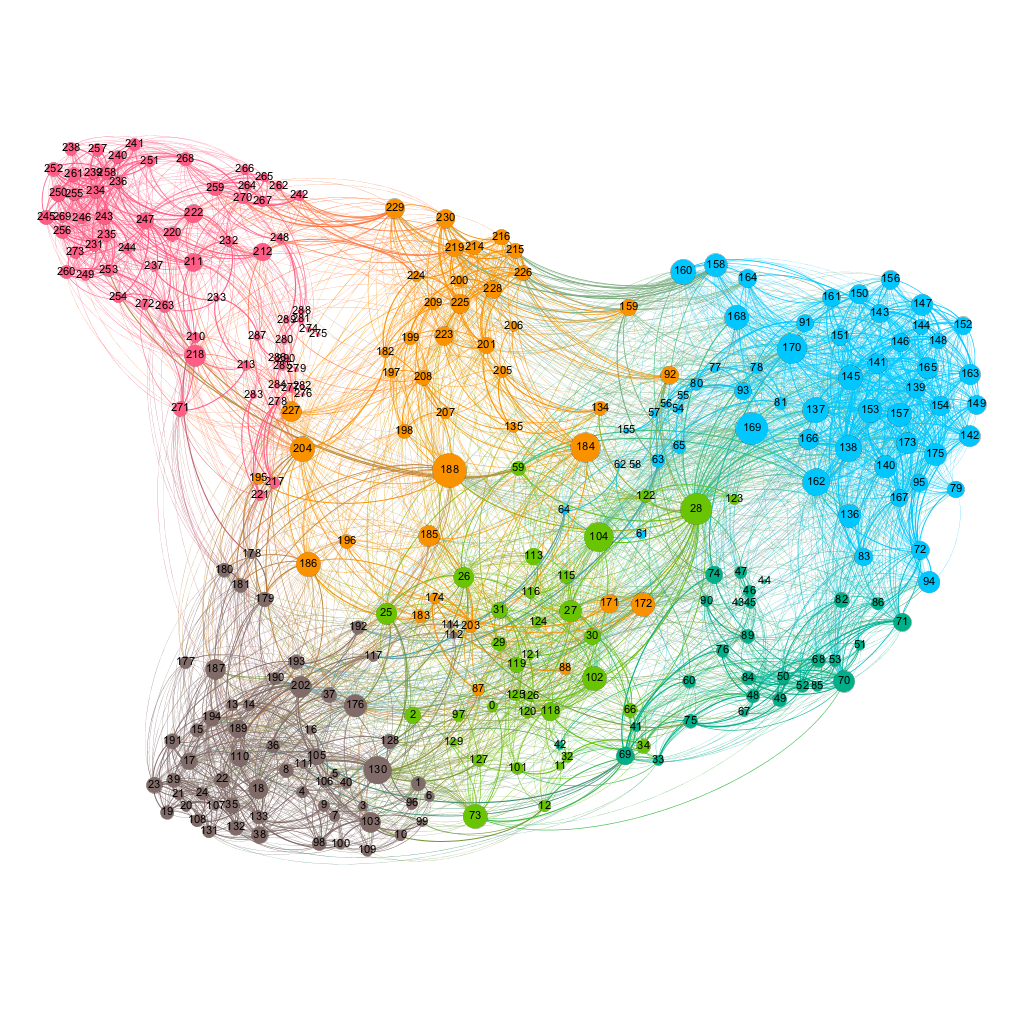

In [37]:
# Poetic License 
# Import gephi network with community detection 
from IPython.display import Image
Image("img/Mouse_Reg_net.png", height= 800, width= 800)

In [38]:
#Grouping each community (for future analysis)
each_community = {}

for key, value in sorted(communities_dict.iteritems()):
    each_community.setdefault(value, []).append(key)
    
# Creating lists by grouping nodes for each community  
community_0 = each_community[0]
community_1 = each_community[1]
community_2 = each_community[2]
community_3 = each_community[3]
community_4 = each_community[4]
community_5 = each_community[5]

# Pairing each node with default structure's acronym 

# list of names associated with nodes number 
com_name_0 = []
com_name_1 = []
com_name_2 = []
com_name_3 = []
com_name_4 = []
com_name_5 = []

# Getting every corresponding name
for i in community_0:
    com_name_0.append(struct_dict[i])
    
for i in community_1:
    com_name_1.append(struct_dict[i])
    
for i in community_2:
    com_name_2.append(struct_dict[i])
    
for i in community_3:
    com_name_3.append(struct_dict[i])
    
for i in community_4:
    com_name_4.append(struct_dict[i])
    
for i in community_5:
    com_name_5.append(struct_dict[i])

# Creating dict with keys = node's # , values = Structure acronym 
com_0_dict = create_dict(community_0, com_name_0)
com_1_dict = create_dict(community_1, com_name_1)
com_2_dict = create_dict(community_2, com_name_2)
com_3_dict = create_dict(community_3, com_name_3)
com_4_dict = create_dict(community_4, com_name_4)
com_5_dict = create_dict(community_5, com_name_5)

In [39]:
# Testing length 
len(com_0_dict) + len(com_1_dict) + len(com_2_dict) + len(com_3_dict) + len(com_4_dict) + len(com_5_dict) == 291

True

# Information Flow Dynamics 

In [40]:
# Import Epydemics on Networks --> lots of models already implemented  
import EoN # Library for Epidemics on Networks
import random # randomize nodes 

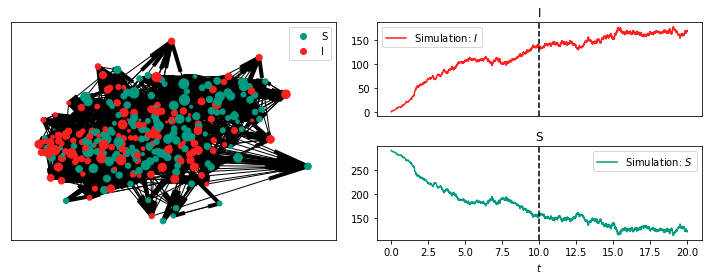

In [41]:
# gamma and tau are typical parameters of our system --> I took them from a paper 
# The epidemic spreading model and the direction of information flow in brain networks -J. Meier et al. 
# (http://dx.doi.org/10.1016/j.neuroimage.2017.02.007)

gamma = 0.5
tau = 0.1

#sim = EoN.fast_SIS(graph_ipsi_tresh, tau, gamma, tmax = 20,initial_infecteds = random.sample(range(0, 291), 1), return_full_data=True)

# take a look on EoN docs --> to be short, it's a stochastic implementation of a SIS model 
sim = EoN.fast_SIS(graph_ipsi_tresh, tau, gamma, tmax = 20,
                            initial_infecteds = 28, return_full_data=True)



sim.display(10,  node_size = [d[v]  for v in range(len(d))], IonTop= False, ts_plots=['I', 'S'], 
            pos = nx.spring_layout(graph_ipsi_tresh, k = 0.4))
plt.show()

# To get .mp4 animation 
#ani=sim.animate(ts_plots=['I', 'S'],node_size = [d[v]  for v in range(len(d))], IonTop= False, pos = nx.spring_layout(graph_ipsi_tresh, k = 0.4))
#ani.save('SISAnimation2.mp4', fps= 5, extra_args=['-vcodec', 'libx264'])

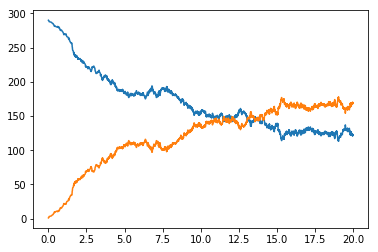

In [48]:
# Plotting Subsceptible (S) and Infected (I) evolution in time
plt.plot(sim.summary()[0],sim.summary()[1])
plt.plot(sim.summary()[0],sim.summary()[2])

# Attack 

In [49]:
# Looking for edges' weights in order to plan an attack on the most important ones  

weights_node0  = []
weights_node1  = []
weights_node2  = []
weights_node3  = []
weights_node4  = []
weights_node5  = []
weights_node6  = []
weights_node7  = []
weights_node8  = []
weights_node9  = []

nodes_from_node0 = []
nodes_from_node1 = []
nodes_from_node2 = []
nodes_from_node3 = []
nodes_from_node4 = []
nodes_from_node5 = []
nodes_from_node6 = []
nodes_from_node7 = []
nodes_from_node8 = []
nodes_from_node9 = []


for i in graph_ipsi_tresh.edges(0):
    weights_node0.append(graph_ipsi_tresh.edges[0, i[1]].values()[0])
    nodes_from_node0.append(i[1])
    
for i in graph_ipsi_tresh.edges(1):
    weights_node1.append(graph_ipsi_tresh.edges[1, i[1]].values()[0])
    nodes_from_node1.append(i[1])

for i in graph_ipsi_tresh.edges(2):
    weights_node2.append(graph_ipsi_tresh.edges[2, i[1]].values()[0])
    nodes_from_node2.append(i[1])
    
for i in graph_ipsi_tresh.edges(3):
    weights_node3.append(graph_ipsi_tresh.edges[3, i[1]].values()[0])
    nodes_from_node3.append(i[1])

for i in graph_ipsi_tresh.edges(4):
    weights_node4.append(graph_ipsi_tresh.edges[4, i[1]].values()[0])
    nodes_from_node4.append(i[1])

for i in graph_ipsi_tresh.edges(5):
    weights_node5.append(graph_ipsi_tresh.edges[5, i[1]].values()[0])
    nodes_from_node5.append(i[1])

for i in graph_ipsi_tresh.edges(6):
    weights_node6.append(graph_ipsi_tresh.edges[6, i[1]].values()[0])
    nodes_from_node6.append(i[1])
    
for i in graph_ipsi_tresh.edges(7):
    weights_node7.append(graph_ipsi_tresh.edges[7, i[1]].values()[0])
    nodes_from_node7.append(i[1])
    
for i in graph_ipsi_tresh.edges(8):
    weights_node8.append(graph_ipsi_tresh.edges[8, i[1]].values()[0])
    nodes_from_node8.append(i[1])
    
for i in graph_ipsi_tresh.edges(9):
    weights_node9.append(graph_ipsi_tresh.edges[9, i[1]].values()[0])
    nodes_from_node9.append(i[1])
    
    

weights_node10 = []
weights_node11  = []
weights_node12  = []
weights_node13 = []
weights_node14 = []
weights_node15 = []
weights_node16 = []
weights_node17 = []
weights_node18 = []
weights_node19 = []

nodes_from_node10 = []
nodes_from_node11 = []
nodes_from_node12 = []
nodes_from_node13 = []
nodes_from_node14 = []
nodes_from_node15 = []
nodes_from_node16 = []
nodes_from_node17 = []
nodes_from_node18 = []
nodes_from_node19 = []


for i in graph_ipsi_tresh.edges(10):
    weights_node10.append(graph_ipsi_tresh.edges[10, i[1]].values()[0])
    nodes_from_node10.append(i[1])
    
for i in graph_ipsi_tresh.edges(11):
    weights_node11.append(graph_ipsi_tresh.edges[11, i[1]].values()[0])
    nodes_from_node11.append(i[1])
    
for i in graph_ipsi_tresh.edges(12):
    weights_node12.append(graph_ipsi_tresh.edges[12, i[1]].values()[0])
    nodes_from_node12.append(i[1])
    
for i in graph_ipsi_tresh.edges(13):
    weights_node13.append(graph_ipsi_tresh.edges[13, i[1]].values()[0])
    nodes_from_node13.append(i[1])

for i in graph_ipsi_tresh.edges(14):
    weights_node14.append(graph_ipsi_tresh.edges[14, i[1]].values()[0])
    nodes_from_node14.append(i[1])

for i in graph_ipsi_tresh.edges(15):
    weights_node15.append(graph_ipsi_tresh.edges[15, i[1]].values()[0])
    nodes_from_node15.append(i[1])

for i in graph_ipsi_tresh.edges(16):
    weights_node16.append(graph_ipsi_tresh.edges[16, i[1]].values()[0])
    nodes_from_node16.append(i[1])
    
for i in graph_ipsi_tresh.edges(17):
    weights_node17.append(graph_ipsi_tresh.edges[17, i[1]].values()[0])
    nodes_from_node17.append(i[1])
    
for i in graph_ipsi_tresh.edges(18):
    weights_node18.append(graph_ipsi_tresh.edges[18, i[1]].values()[0])
    nodes_from_node18.append(i[1])
    
for i in graph_ipsi_tresh.edges(19):
    weights_node19.append(graph_ipsi_tresh.edges[19, i[1]].values()[0])
    nodes_from_node19.append(i[1])
    
    

weights_node20  = []
weights_node21 = []
weights_node22 = []
weights_node23 = []
weights_node24 = []
weights_node25 = []
weights_node26 = []
weights_node27 = []
weights_node28 = []
weights_node29 = []

nodes_from_node20 = []
nodes_from_node21 = []
nodes_from_node22 = []
nodes_from_node23 = []
nodes_from_node24 = []
nodes_from_node25 = []
nodes_from_node26 = []
nodes_from_node27 = []
nodes_from_node28 = []
nodes_from_node29 = []



for i in graph_ipsi_tresh.edges(20):
    weights_node20.append(graph_ipsi_tresh.edges[20, i[1]].values()[0])
    nodes_from_node20.append(i[1])
    
for i in graph_ipsi_tresh.edges(21):
    weights_node21.append(graph_ipsi_tresh.edges[21, i[1]].values()[0])
    nodes_from_node21.append(i[1])

for i in graph_ipsi_tresh.edges(22):
    weights_node22.append(graph_ipsi_tresh.edges[22, i[1]].values()[0])
    nodes_from_node22.append(i[1])

for i in graph_ipsi_tresh.edges(23):
    weights_node23.append(graph_ipsi_tresh.edges[23, i[1]].values()[0])
    nodes_from_node23.append(i[1])

for i in graph_ipsi_tresh.edges(24):
    weights_node24.append(graph_ipsi_tresh.edges[24, i[1]].values()[0])
    nodes_from_node24.append(i[1])

for i in graph_ipsi_tresh.edges(25):
    weights_node25.append(graph_ipsi_tresh.edges[25, i[1]].values()[0])
    nodes_from_node25.append(i[1])

for i in graph_ipsi_tresh.edges(26):
    weights_node26.append(graph_ipsi_tresh.edges[26, i[1]].values()[0])
    nodes_from_node26.append(i[1])
    
for i in graph_ipsi_tresh.edges(27):
    weights_node27.append(graph_ipsi_tresh.edges[27, i[1]].values()[0])
    nodes_from_node27.append(i[1])
    
for i in graph_ipsi_tresh.edges(28):
    weights_node28.append(graph_ipsi_tresh.edges[28, i[1]].values()[0])
    nodes_from_node28.append(i[1])
    
for i in graph_ipsi_tresh.edges(29):
    weights_node29.append(graph_ipsi_tresh.edges[29, i[1]].values()[0])
    nodes_from_node29.append(i[1])
    
    
weights_node30  = []
weights_node31  = []
weights_node32  = []
weights_node33  = []
weights_node34  = []
weights_node35  = []
weights_node36  = []
weights_node37  = []
weights_node38  = []
weights_node39  = []

nodes_from_node30 = []
nodes_from_node31 = []
nodes_from_node32 = []
nodes_from_node33 = []
nodes_from_node34 = []
nodes_from_node35 = []
nodes_from_node36 = []
nodes_from_node37 = []
nodes_from_node38 = []
nodes_from_node39 = []


for i in graph_ipsi_tresh.edges(30):
    weights_node30.append(graph_ipsi_tresh.edges[30, i[1]].values()[0])
    nodes_from_node30.append(i[1])
    
for i in graph_ipsi_tresh.edges(31):
    weights_node31.append(graph_ipsi_tresh.edges[31, i[1]].values()[0])
    nodes_from_node31.append(i[1])

for i in graph_ipsi_tresh.edges(32):
    weights_node32.append(graph_ipsi_tresh.edges[32, i[1]].values()[0])
    nodes_from_node32.append(i[1])

for i in graph_ipsi_tresh.edges(33):
    weights_node33.append(graph_ipsi_tresh.edges[33, i[1]].values()[0])
    nodes_from_node33.append(i[1])

for i in graph_ipsi_tresh.edges(34):
    weights_node34.append(graph_ipsi_tresh.edges[34, i[1]].values()[0])
    nodes_from_node34.append(i[1])

for i in graph_ipsi_tresh.edges(35):
    weights_node35.append(graph_ipsi_tresh.edges[35, i[1]].values()[0])
    nodes_from_node35.append(i[1])

for i in graph_ipsi_tresh.edges(36):
    weights_node36.append(graph_ipsi_tresh.edges[36, i[1]].values()[0])
    nodes_from_node36.append(i[1])
    
for i in graph_ipsi_tresh.edges(37):
    weights_node37.append(graph_ipsi_tresh.edges[37, i[1]].values()[0])
    nodes_from_node37.append(i[1])
    
for i in graph_ipsi_tresh.edges(38):
    weights_node38.append(graph_ipsi_tresh.edges[38, i[1]].values()[0])
    nodes_from_node38.append(i[1])
    
for i in graph_ipsi_tresh.edges(39):
    weights_node39.append(graph_ipsi_tresh.edges[39, i[1]].values()[0])
    nodes_from_node39.append(i[1])
    

weights_node40  = []
weights_node41  = []
weights_node42  = []
weights_node43  = []
weights_node44  = []
weights_node45  = []
weights_node46  = []
weights_node47  = []
weights_node48  = []
weights_node49  = []

nodes_from_node40 = []
nodes_from_node41 = []
nodes_from_node42 = []
nodes_from_node43 = []
nodes_from_node44 = []
nodes_from_node45 = []
nodes_from_node46 = []
nodes_from_node47 = []
nodes_from_node48 = []
nodes_from_node49 = []



for i in graph_ipsi_tresh.edges(40):
    weights_node40.append(graph_ipsi_tresh.edges[40, i[1]].values()[0])
    nodes_from_node40.append(i[1])
    
for i in graph_ipsi_tresh.edges(41):
    weights_node41.append(graph_ipsi_tresh.edges[41, i[1]].values()[0])
    nodes_from_node41.append(i[1])
    
for i in graph_ipsi_tresh.edges(42):
    weights_node42.append(graph_ipsi_tresh.edges[42, i[1]].values()[0])
    nodes_from_node42.append(i[1])
    

for i in graph_ipsi_tresh.edges(43):
    weights_node43.append(graph_ipsi_tresh.edges[43, i[1]].values()[0])
    nodes_from_node43.append(i[1])

for i in graph_ipsi_tresh.edges(44):
    weights_node44.append(graph_ipsi_tresh.edges[44, i[1]].values()[0])
    nodes_from_node44.append(i[1])

for i in graph_ipsi_tresh.edges(45):
    weights_node45.append(graph_ipsi_tresh.edges[45, i[1]].values()[0])
    nodes_from_node45.append(i[1])

for i in graph_ipsi_tresh.edges(46):
    weights_node46.append(graph_ipsi_tresh.edges[46, i[1]].values()[0])
    nodes_from_node46.append(i[1])
    
for i in graph_ipsi_tresh.edges(47):
    weights_node47.append(graph_ipsi_tresh.edges[47, i[1]].values()[0])
    nodes_from_node47.append(i[1])
    
for i in graph_ipsi_tresh.edges(48):
    weights_node48.append(graph_ipsi_tresh.edges[48, i[1]].values()[0])
    nodes_from_node48.append(i[1])
    
for i in graph_ipsi_tresh.edges(49):
    weights_node49.append(graph_ipsi_tresh.edges[49, i[1]].values()[0])
    nodes_from_node49.append(i[1])
    

weights_node50  = []
weights_node51  = []
weights_node52  = []
weights_node53  = []
weights_node54  = []
weights_node55  = []
weights_node56  = []
weights_node57  = []
weights_node58  = []
weights_node59  = []

nodes_from_node50 = []
nodes_from_node51 = []
nodes_from_node52 = []
nodes_from_node53 = []
nodes_from_node54 = []
nodes_from_node55 = []
nodes_from_node56 = []
nodes_from_node57 = []
nodes_from_node58 = []
nodes_from_node59 = []


for i in graph_ipsi_tresh.edges(50):
    weights_node50.append(graph_ipsi_tresh.edges[50, i[1]].values()[0])
    nodes_from_node50.append(i[1])
    
for i in graph_ipsi_tresh.edges(51):
    weights_node51.append(graph_ipsi_tresh.edges[51, i[1]].values()[0])
    nodes_from_node51.append(i[1])

for i in graph_ipsi_tresh.edges(52):
    weights_node52.append(graph_ipsi_tresh.edges[52, i[1]].values()[0])
    nodes_from_node52.append(i[1])

for i in graph_ipsi_tresh.edges(53):
    weights_node53.append(graph_ipsi_tresh.edges[53, i[1]].values()[0])
    nodes_from_node53.append(i[1])

for i in graph_ipsi_tresh.edges(54):
    weights_node54.append(graph_ipsi_tresh.edges[54, i[1]].values()[0])
    nodes_from_node54.append(i[1])

for i in graph_ipsi_tresh.edges(55):
    weights_node55.append(graph_ipsi_tresh.edges[55, i[1]].values()[0])
    nodes_from_node55.append(i[1])

for i in graph_ipsi_tresh.edges(56):
    weights_node56.append(graph_ipsi_tresh.edges[56, i[1]].values()[0])
    nodes_from_node56.append(i[1])
    
for i in graph_ipsi_tresh.edges(57):
    weights_node57.append(graph_ipsi_tresh.edges[57, i[1]].values()[0])
    nodes_from_node57.append(i[1])
    
for i in graph_ipsi_tresh.edges(58):
    weights_node58.append(graph_ipsi_tresh.edges[58, i[1]].values()[0])
    nodes_from_node58.append(i[1])
    
for i in graph_ipsi_tresh.edges(59):
    weights_node59.append(graph_ipsi_tresh.edges[59, i[1]].values()[0])
    nodes_from_node59.append(i[1])
    

weights_node60  = []
weights_node61  = []
weights_node62  = []
weights_node63  = []
weights_node64  = []
weights_node65  = []
weights_node66  = []
weights_node67  = []
weights_node68  = []
weights_node69  = []

nodes_from_node60 = []
nodes_from_node61 = []
nodes_from_node62 = []
nodes_from_node63 = []
nodes_from_node64 = []
nodes_from_node65 = []
nodes_from_node66 = []
nodes_from_node67 = []
nodes_from_node68 = []
nodes_from_node69 = []

for i in graph_ipsi_tresh.edges(60):
    weights_node60.append(graph_ipsi_tresh.edges[60, i[1]].values()[0])
    nodes_from_node60.append(i[1])
    
    
for i in graph_ipsi_tresh.edges(61):
    weights_node61.append(graph_ipsi_tresh.edges[61, i[1]].values()[0])
    nodes_from_node61.append(i[1])

for i in graph_ipsi_tresh.edges(62):
    weights_node62.append(graph_ipsi_tresh.edges[62, i[1]].values()[0])
    nodes_from_node62.append(i[1])

for i in graph_ipsi_tresh.edges(63):
    weights_node63.append(graph_ipsi_tresh.edges[63, i[1]].values()[0])
    nodes_from_node63.append(i[1])

for i in graph_ipsi_tresh.edges(64):
    weights_node64.append(graph_ipsi_tresh.edges[64, i[1]].values()[0])
    nodes_from_node64.append(i[1])

for i in graph_ipsi_tresh.edges(65):
    weights_node65.append(graph_ipsi_tresh.edges[65, i[1]].values()[0])
    nodes_from_node65.append(i[1])

for i in graph_ipsi_tresh.edges(66):
    weights_node66.append(graph_ipsi_tresh.edges[66, i[1]].values()[0])
    nodes_from_node66.append(i[1])
    
for i in graph_ipsi_tresh.edges(67):
    weights_node67.append(graph_ipsi_tresh.edges[67, i[1]].values()[0])
    nodes_from_node67.append(i[1])
    
for i in graph_ipsi_tresh.edges(68):
    weights_node68.append(graph_ipsi_tresh.edges[68, i[1]].values()[0])
    nodes_from_node68.append(i[1])
    
for i in graph_ipsi_tresh.edges(69):
    weights_node69.append(graph_ipsi_tresh.edges[69, i[1]].values()[0])
    nodes_from_node69.append(i[1])
    
    

weights_node70  = []
weights_node71  = []
weights_node72  = []
weights_node73  = []
weights_node74  = []
weights_node75  = []
weights_node76  = []
weights_node77  = []
weights_node78  = []
weights_node79  = []

nodes_from_node70 = []
nodes_from_node71 = []
nodes_from_node72 = []
nodes_from_node73 = []
nodes_from_node74 = []
nodes_from_node75 = []
nodes_from_node76 = []
nodes_from_node77 = []
nodes_from_node78 = []
nodes_from_node79 = []

for i in graph_ipsi_tresh.edges(70):
    weights_node70.append(graph_ipsi_tresh.edges[70, i[1]].values()[0])
    nodes_from_node70.append(i[1])
    
for i in graph_ipsi_tresh.edges(71):
    weights_node71.append(graph_ipsi_tresh.edges[71, i[1]].values()[0])
    nodes_from_node71.append(i[1])

for i in graph_ipsi_tresh.edges(72):
    weights_node72.append(graph_ipsi_tresh.edges[72, i[1]].values()[0])
    nodes_from_node72.append(i[1])

for i in graph_ipsi_tresh.edges(73):
    weights_node73.append(graph_ipsi_tresh.edges[73, i[1]].values()[0])
    nodes_from_node73.append(i[1])

for i in graph_ipsi_tresh.edges(74):
    weights_node74.append(graph_ipsi_tresh.edges[74, i[1]].values()[0])
    nodes_from_node74.append(i[1])

for i in graph_ipsi_tresh.edges(75):
    weights_node75.append(graph_ipsi_tresh.edges[75, i[1]].values()[0])
    nodes_from_node75.append(i[1])

for i in graph_ipsi_tresh.edges(76):
    weights_node76.append(graph_ipsi_tresh.edges[76, i[1]].values()[0])
    nodes_from_node76.append(i[1])
    
for i in graph_ipsi_tresh.edges(77):
    weights_node77.append(graph_ipsi_tresh.edges[77, i[1]].values()[0])
    nodes_from_node77.append(i[1])
    
for i in graph_ipsi_tresh.edges(78):
    weights_node78.append(graph_ipsi_tresh.edges[78, i[1]].values()[0])
    nodes_from_node78.append(i[1])
    
for i in graph_ipsi_tresh.edges(79):
    weights_node79.append(graph_ipsi_tresh.edges[79, i[1]].values()[0])
    nodes_from_node79.append(i[1])
        

weights_node80  = []
weights_node81  = []
weights_node82  = []
weights_node83  = []
weights_node84  = []
weights_node85  = []
weights_node86  = []
weights_node87  = []
weights_node88  = []
weights_node89  = []

nodes_from_node80 = []
nodes_from_node81 = []
nodes_from_node82 = []
nodes_from_node83 = []
nodes_from_node84 = []
nodes_from_node85 = []
nodes_from_node86 = []
nodes_from_node87 = []
nodes_from_node88 = []
nodes_from_node89 = []


for i in graph_ipsi_tresh.edges(80):
    weights_node80.append(graph_ipsi_tresh.edges[80, i[1]].values()[0])
    nodes_from_node80.append(i[1])
    
for i in graph_ipsi_tresh.edges(81):
    weights_node81.append(graph_ipsi_tresh.edges[81, i[1]].values()[0])
    nodes_from_node81.append(i[1])

for i in graph_ipsi_tresh.edges(82):
    weights_node82.append(graph_ipsi_tresh.edges[82, i[1]].values()[0])
    nodes_from_node82.append(i[1])

for i in graph_ipsi_tresh.edges(83):
    weights_node83.append(graph_ipsi_tresh.edges[83, i[1]].values()[0])
    nodes_from_node83.append(i[1])

for i in graph_ipsi_tresh.edges(84):
    weights_node84.append(graph_ipsi_tresh.edges[84, i[1]].values()[0])
    nodes_from_node84.append(i[1])

for i in graph_ipsi_tresh.edges(85):
    weights_node85.append(graph_ipsi_tresh.edges[85, i[1]].values()[0])
    nodes_from_node85.append(i[1])

for i in graph_ipsi_tresh.edges(86):
    weights_node86.append(graph_ipsi_tresh.edges[86, i[1]].values()[0])
    nodes_from_node86.append(i[1])
    
for i in graph_ipsi_tresh.edges(87):
    weights_node87.append(graph_ipsi_tresh.edges[87, i[1]].values()[0])
    nodes_from_node87.append(i[1])
    
for i in graph_ipsi_tresh.edges(88):
    weights_node88.append(graph_ipsi_tresh.edges[88, i[1]].values()[0])
    nodes_from_node88.append(i[1])
    
for i in graph_ipsi_tresh.edges(89):
    weights_node89.append(graph_ipsi_tresh.edges[89, i[1]].values()[0])
    nodes_from_node89.append(i[1])
        

weights_node90  = []
weights_node91  = []
weights_node92  = []
weights_node93  = []
weights_node94  = []
weights_node95  = []
weights_node96  = []
weights_node97  = []
weights_node98  = []
weights_node99 =  []

nodes_from_node90 = []
nodes_from_node91 = []
nodes_from_node92 = []
nodes_from_node93 = []
nodes_from_node94 = []
nodes_from_node95 = []
nodes_from_node96 = []
nodes_from_node97 = []
nodes_from_node98 = []
nodes_from_node99 = []


for i in graph_ipsi_tresh.edges(90):
    weights_node90.append(graph_ipsi_tresh.edges[90, i[1]].values()[0])
    nodes_from_node90.append(i[1])
    
for i in graph_ipsi_tresh.edges(91):
    weights_node91.append(graph_ipsi_tresh.edges[91, i[1]].values()[0])
    nodes_from_node91.append(i[1])

for i in graph_ipsi_tresh.edges(92):
    weights_node92.append(graph_ipsi_tresh.edges[92, i[1]].values()[0])
    nodes_from_node92.append(i[1])

for i in graph_ipsi_tresh.edges(93):
    weights_node93.append(graph_ipsi_tresh.edges[93, i[1]].values()[0])
    nodes_from_node93.append(i[1])

for i in graph_ipsi_tresh.edges(94):
    weights_node94.append(graph_ipsi_tresh.edges[94, i[1]].values()[0])
    nodes_from_node94.append(i[1])

for i in graph_ipsi_tresh.edges(95):
    weights_node95.append(graph_ipsi_tresh.edges[95, i[1]].values()[0])
    nodes_from_node95.append(i[1])

for i in graph_ipsi_tresh.edges(96):
    weights_node96.append(graph_ipsi_tresh.edges[96, i[1]].values()[0])
    nodes_from_node96.append(i[1])
    
for i in graph_ipsi_tresh.edges(97):
    weights_node97.append(graph_ipsi_tresh.edges[97, i[1]].values()[0])
    nodes_from_node97.append(i[1])
    
for i in graph_ipsi_tresh.edges(98):
    weights_node98.append(graph_ipsi_tresh.edges[98, i[1]].values()[0])
    nodes_from_node98.append(i[1])
    
for i in graph_ipsi_tresh.edges(99):
    weights_node99.append(graph_ipsi_tresh.edges[99, i[1]].values()[0])
    nodes_from_node99.append(i[1])
    
    
weights_node100  = []
weights_node101  = []
weights_node102  = []
weights_node103  = []
weights_node104  = []
weights_node105  = []
weights_node106  = []
weights_node107  = []
weights_node108  = []
weights_node109  = []

nodes_from_node100 = []
nodes_from_node101 = []
nodes_from_node102 = []
nodes_from_node103 = []
nodes_from_node104 = []
nodes_from_node105 = []
nodes_from_node106 = []
nodes_from_node107 = []
nodes_from_node108 = []
nodes_from_node109 = []


for i in graph_ipsi_tresh.edges(100):
    weights_node100.append(graph_ipsi_tresh.edges[100, i[1]].values()[0])
    nodes_from_node100.append(i[1])
    
for i in graph_ipsi_tresh.edges(101):
    weights_node101.append(graph_ipsi_tresh.edges[101, i[1]].values()[0])
    nodes_from_node101.append(i[1])

for i in graph_ipsi_tresh.edges(102):
    weights_node102.append(graph_ipsi_tresh.edges[102, i[1]].values()[0])
    nodes_from_node102.append(i[1])

for i in graph_ipsi_tresh.edges(103):
    weights_node103.append(graph_ipsi_tresh.edges[103, i[1]].values()[0])
    nodes_from_node103.append(i[1])

for i in graph_ipsi_tresh.edges(104):
    weights_node104.append(graph_ipsi_tresh.edges[104, i[1]].values()[0])
    nodes_from_node104.append(i[1])

for i in graph_ipsi_tresh.edges(105):
    weights_node105.append(graph_ipsi_tresh.edges[105, i[1]].values()[0])
    nodes_from_node105.append(i[1])

for i in graph_ipsi_tresh.edges(106):
    weights_node106.append(graph_ipsi_tresh.edges[106, i[1]].values()[0])
    nodes_from_node106.append(i[1])
    
for i in graph_ipsi_tresh.edges(107):
    weights_node107.append(graph_ipsi_tresh.edges[107, i[1]].values()[0])
    nodes_from_node107.append(i[1])
    
for i in graph_ipsi_tresh.edges(108):
    weights_node108.append(graph_ipsi_tresh.edges[108, i[1]].values()[0])
    nodes_from_node108.append(i[1])
    
for i in graph_ipsi_tresh.edges(109):
    weights_node109.append(graph_ipsi_tresh.edges[109, i[1]].values()[0])
    nodes_from_node109.append(i[1])

weights_node110  = []
weights_node111  = []
weights_node112  = []
weights_node113  = []
weights_node114  = []
weights_node115  = []
weights_node116  = []
weights_node117  = []
weights_node118  = []
weights_node119 = []

nodes_from_node110 = []
nodes_from_node111 = []
nodes_from_node112 = []
nodes_from_node113 = []
nodes_from_node114 = []
nodes_from_node115 = []
nodes_from_node116 = []
nodes_from_node117 = []
nodes_from_node118 = []
nodes_from_node119 = []

for i in graph_ipsi_tresh.edges(110):
    weights_node110.append(graph_ipsi_tresh.edges[110, i[1]].values()[0])
    nodes_from_node110.append(i[1])
    
for i in graph_ipsi_tresh.edges(111):
    weights_node111.append(graph_ipsi_tresh.edges[111, i[1]].values()[0])
    nodes_from_node111.append(i[1])

for i in graph_ipsi_tresh.edges(112):
    weights_node112.append(graph_ipsi_tresh.edges[112, i[1]].values()[0])
    nodes_from_node112.append(i[1])

for i in graph_ipsi_tresh.edges(113):
    weights_node113.append(graph_ipsi_tresh.edges[113, i[1]].values()[0])
    nodes_from_node113.append(i[1])

for i in graph_ipsi_tresh.edges(114):
    weights_node114.append(graph_ipsi_tresh.edges[114, i[1]].values()[0])
    nodes_from_node114.append(i[1])

for i in graph_ipsi_tresh.edges(115):
    weights_node115.append(graph_ipsi_tresh.edges[115, i[1]].values()[0])
    nodes_from_node115.append(i[1])

for i in graph_ipsi_tresh.edges(116):
    weights_node116.append(graph_ipsi_tresh.edges[116, i[1]].values()[0])
    nodes_from_node116.append(i[1])
    
for i in graph_ipsi_tresh.edges(117):
    weights_node117.append(graph_ipsi_tresh.edges[117, i[1]].values()[0])
    nodes_from_node117.append(i[1])
    
for i in graph_ipsi_tresh.edges(118):
    weights_node118.append(graph_ipsi_tresh.edges[118, i[1]].values()[0])
    nodes_from_node118.append(i[1])
    
for i in graph_ipsi_tresh.edges(119):
    weights_node119.append(graph_ipsi_tresh.edges[119, i[1]].values()[0])
    nodes_from_node119.append(i[1])

weights_node120  = []
weights_node121  = []
weights_node122  = []
weights_node123  = []
weights_node124  = []
weights_node125  = []
weights_node126  = []
weights_node127  = []
weights_node128  = []
weights_node129  = []

nodes_from_node120 = []
nodes_from_node121 = []
nodes_from_node122 = []
nodes_from_node123 = []
nodes_from_node124 = []
nodes_from_node125 = []
nodes_from_node126 = []
nodes_from_node127 = []
nodes_from_node128 = []
nodes_from_node129 = []

for i in graph_ipsi_tresh.edges(120):
    weights_node120.append(graph_ipsi_tresh.edges[120, i[1]].values()[0])
    nodes_from_node120.append(i[1])
    
for i in graph_ipsi_tresh.edges(121):
    weights_node121.append(graph_ipsi_tresh.edges[121, i[1]].values()[0])
    nodes_from_node121.append(i[1])

for i in graph_ipsi_tresh.edges(122):
    weights_node122.append(graph_ipsi_tresh.edges[122, i[1]].values()[0])
    nodes_from_node122.append(i[1])

for i in graph_ipsi_tresh.edges(123):
    weights_node123.append(graph_ipsi_tresh.edges[123, i[1]].values()[0])
    nodes_from_node123.append(i[1])

for i in graph_ipsi_tresh.edges(124):
    weights_node124.append(graph_ipsi_tresh.edges[124, i[1]].values()[0])
    nodes_from_node124.append(i[1])

for i in graph_ipsi_tresh.edges(125):
    weights_node125.append(graph_ipsi_tresh.edges[125, i[1]].values()[0])
    nodes_from_node125.append(i[1])

for i in graph_ipsi_tresh.edges(126):
    weights_node126.append(graph_ipsi_tresh.edges[126, i[1]].values()[0])
    nodes_from_node126.append(i[1])
    
for i in graph_ipsi_tresh.edges(127):
    weights_node127.append(graph_ipsi_tresh.edges[127, i[1]].values()[0])
    nodes_from_node127.append(i[1])
    
for i in graph_ipsi_tresh.edges(128):
    weights_node128.append(graph_ipsi_tresh.edges[128, i[1]].values()[0])
    nodes_from_node128.append(i[1])
    
for i in graph_ipsi_tresh.edges(129):
    weights_node129.append(graph_ipsi_tresh.edges[129, i[1]].values()[0])
    nodes_from_node129.append(i[1])

weights_node130  = []
weights_node131  = []
weights_node132  = []
weights_node133  = []
weights_node134  = []
weights_node135  = []
weights_node136  = []
weights_node137  = []
weights_node138  = []
weights_node139  = []

nodes_from_node130 = []
nodes_from_node131 = []
nodes_from_node132 = []
nodes_from_node133 = []
nodes_from_node134 = []
nodes_from_node135 = []
nodes_from_node136 = []
nodes_from_node137 = []
nodes_from_node138 = []
nodes_from_node139 = []

for i in graph_ipsi_tresh.edges(130):
    weights_node130.append(graph_ipsi_tresh.edges[130, i[1]].values()[0])
    nodes_from_node130.append(i[1])
    
for i in graph_ipsi_tresh.edges(131):
    weights_node131.append(graph_ipsi_tresh.edges[131, i[1]].values()[0])
    nodes_from_node131.append(i[1])

for i in graph_ipsi_tresh.edges(132):
    weights_node132.append(graph_ipsi_tresh.edges[132, i[1]].values()[0])
    nodes_from_node132.append(i[1])

for i in graph_ipsi_tresh.edges(133):
    weights_node133.append(graph_ipsi_tresh.edges[133, i[1]].values()[0])
    nodes_from_node133.append(i[1])

for i in graph_ipsi_tresh.edges(134):
    weights_node134.append(graph_ipsi_tresh.edges[134, i[1]].values()[0])
    nodes_from_node134.append(i[1])
    
for i in graph_ipsi_tresh.edges(135):
    weights_node135.append(graph_ipsi_tresh.edges[135, i[1]].values()[0])
    nodes_from_node135.append(i[1])

for i in graph_ipsi_tresh.edges(136):
    weights_node136.append(graph_ipsi_tresh.edges[136, i[1]].values()[0])
    nodes_from_node136.append(i[1])
    
for i in graph_ipsi_tresh.edges(137):
    weights_node137.append(graph_ipsi_tresh.edges[137, i[1]].values()[0])
    nodes_from_node137.append(i[1])
    
for i in graph_ipsi_tresh.edges(138):
    weights_node138.append(graph_ipsi_tresh.edges[138, i[1]].values()[0])
    nodes_from_node138.append(i[1])
    
for i in graph_ipsi_tresh.edges(139):
    weights_node139.append(graph_ipsi_tresh.edges[139, i[1]].values()[0])
    nodes_from_node139.append(i[1])

weights_node140  = []
weights_node141  = []
weights_node142  = []
weights_node143  = []
weights_node144  = []
weights_node145  = []
weights_node146  = []
weights_node147  = []
weights_node148  = []
weights_node149  = []

nodes_from_node140 = []
nodes_from_node141 = []
nodes_from_node142 = []
nodes_from_node143 = []
nodes_from_node144 = []
nodes_from_node145 = []
nodes_from_node146 = []
nodes_from_node147 = []
nodes_from_node148 = []
nodes_from_node149 = []

for i in graph_ipsi_tresh.edges(140):
    weights_node140.append(graph_ipsi_tresh.edges[140, i[1]].values()[0])
    nodes_from_node140.append(i[1])
    
for i in graph_ipsi_tresh.edges(141):
    weights_node141.append(graph_ipsi_tresh.edges[141, i[1]].values()[0])
    nodes_from_node141.append(i[1])

for i in graph_ipsi_tresh.edges(142):
    weights_node142.append(graph_ipsi_tresh.edges[142, i[1]].values()[0])
    nodes_from_node142.append(i[1])

for i in graph_ipsi_tresh.edges(143):
    weights_node143.append(graph_ipsi_tresh.edges[143, i[1]].values()[0])
    nodes_from_node143.append(i[1])

for i in graph_ipsi_tresh.edges(144):
    weights_node144.append(graph_ipsi_tresh.edges[144, i[1]].values()[0])
    nodes_from_node144.append(i[1])

for i in graph_ipsi_tresh.edges(145):
    weights_node145.append(graph_ipsi_tresh.edges[145, i[1]].values()[0])
    nodes_from_node145.append(i[1])

for i in graph_ipsi_tresh.edges(146):
    weights_node146.append(graph_ipsi_tresh.edges[146, i[1]].values()[0])
    nodes_from_node146.append(i[1])
    
for i in graph_ipsi_tresh.edges(147):
    weights_node147.append(graph_ipsi_tresh.edges[147, i[1]].values()[0])
    nodes_from_node147.append(i[1])
    
for i in graph_ipsi_tresh.edges(148):
    weights_node148.append(graph_ipsi_tresh.edges[148, i[1]].values()[0])
    nodes_from_node148.append(i[1])
    
for i in graph_ipsi_tresh.edges(149):
    weights_node149.append(graph_ipsi_tresh.edges[149, i[1]].values()[0])
    nodes_from_node149.append(i[1])

weights_node150  = []
weights_node151  = []
weights_node152  = []
weights_node153  = []
weights_node154  = []
weights_node155  = []
weights_node156  = []
weights_node157  = []
weights_node158  = []
weights_node159  = []

nodes_from_node150 = []
nodes_from_node151 = []
nodes_from_node152 = []
nodes_from_node153 = []
nodes_from_node154 = []
nodes_from_node155 = []
nodes_from_node156 = []
nodes_from_node157 = []
nodes_from_node158 = []
nodes_from_node159 = []

for i in graph_ipsi_tresh.edges(150):
    weights_node150.append(graph_ipsi_tresh.edges[150, i[1]].values()[0])
    nodes_from_node150.append(i[1])
    
for i in graph_ipsi_tresh.edges(151):
    weights_node151.append(graph_ipsi_tresh.edges[151, i[1]].values()[0])
    nodes_from_node151.append(i[1])
    
for i in graph_ipsi_tresh.edges(152):
    weights_node152.append(graph_ipsi_tresh.edges[152, i[1]].values()[0])
    nodes_from_node152.append(i[1])

for i in graph_ipsi_tresh.edges(153):
    weights_node153.append(graph_ipsi_tresh.edges[153, i[1]].values()[0])
    nodes_from_node153.append(i[1])

for i in graph_ipsi_tresh.edges(154):
    weights_node154.append(graph_ipsi_tresh.edges[154, i[1]].values()[0])
    nodes_from_node154.append(i[1])

for i in graph_ipsi_tresh.edges(155):
    weights_node155.append(graph_ipsi_tresh.edges[155, i[1]].values()[0])
    nodes_from_node155.append(i[1])

for i in graph_ipsi_tresh.edges(156):
    weights_node156.append(graph_ipsi_tresh.edges[156, i[1]].values()[0])
    nodes_from_node156.append(i[1])
    
for i in graph_ipsi_tresh.edges(157):
    weights_node157.append(graph_ipsi_tresh.edges[157, i[1]].values()[0])
    nodes_from_node157.append(i[1])
    
for i in graph_ipsi_tresh.edges(158):
    weights_node158.append(graph_ipsi_tresh.edges[158, i[1]].values()[0])
    nodes_from_node158.append(i[1])
    
for i in graph_ipsi_tresh.edges(159):
    weights_node159.append(graph_ipsi_tresh.edges[159, i[1]].values()[0])
    nodes_from_node159.append(i[1])
    
weights_node160  = []
weights_node161  = []
weights_node162  = []
weights_node163  = []
weights_node164  = []
weights_node165  = []
weights_node166  = []
weights_node167  = []
weights_node168  = []
weights_node169  = []

nodes_from_node160 = []
nodes_from_node161 = []
nodes_from_node162 = []
nodes_from_node163 = []
nodes_from_node164 = []
nodes_from_node165 = []
nodes_from_node166 = []
nodes_from_node167 = []
nodes_from_node168 = []
nodes_from_node169 = []

for i in graph_ipsi_tresh.edges(160):
    weights_node160.append(graph_ipsi_tresh.edges[160, i[1]].values()[0])
    nodes_from_node160.append(i[1])
    
for i in graph_ipsi_tresh.edges(161):
    weights_node161.append(graph_ipsi_tresh.edges[161, i[1]].values()[0])
    nodes_from_node161.append(i[1])

for i in graph_ipsi_tresh.edges(162):
    weights_node162.append(graph_ipsi_tresh.edges[162, i[1]].values()[0])
    nodes_from_node162.append(i[1])
    
for i in graph_ipsi_tresh.edges(163):
    weights_node163.append(graph_ipsi_tresh.edges[163, i[1]].values()[0])
    nodes_from_node163.append(i[1])

for i in graph_ipsi_tresh.edges(164):
    weights_node164.append(graph_ipsi_tresh.edges[164, i[1]].values()[0])
    nodes_from_node164.append(i[1])

for i in graph_ipsi_tresh.edges(165):
    weights_node165.append(graph_ipsi_tresh.edges[165, i[1]].values()[0])
    nodes_from_node165.append(i[1])

for i in graph_ipsi_tresh.edges(166):
    weights_node166.append(graph_ipsi_tresh.edges[166, i[1]].values()[0])
    nodes_from_node166.append(i[1])
    
for i in graph_ipsi_tresh.edges(167):
    weights_node167.append(graph_ipsi_tresh.edges[167, i[1]].values()[0])
    
for i in graph_ipsi_tresh.edges(168):
    weights_node168.append(graph_ipsi_tresh.edges[168, i[1]].values()[0])
    nodes_from_node168.append(i[1])
    
for i in graph_ipsi_tresh.edges(169):
    weights_node169.append(graph_ipsi_tresh.edges[169, i[1]].values()[0])
    nodes_from_node169.append(i[1])

weights_node170  = []
weights_node171  = []
weights_node172  = []
weights_node173  = []
weights_node174  = []
weights_node175  = []
weights_node176  = []
weights_node177  = []
weights_node178  = []
weights_node179  = []

nodes_from_node170 = []
nodes_from_node171 = []
nodes_from_node172 = []
nodes_from_node173 = []
nodes_from_node174 = []
nodes_from_node175 = []
nodes_from_node176 = []
nodes_from_node177 = []
nodes_from_node178 = []
nodes_from_node179 = []

for i in graph_ipsi_tresh.edges(170):
    weights_node170.append(graph_ipsi_tresh.edges[170, i[1]].values()[0])
    nodes_from_node170.append(i[1])
    
for i in graph_ipsi_tresh.edges(171):
    weights_node171.append(graph_ipsi_tresh.edges[171, i[1]].values()[0])
    nodes_from_node171.append(i[1])

for i in graph_ipsi_tresh.edges(172):
    weights_node172.append(graph_ipsi_tresh.edges[172, i[1]].values()[0])
    nodes_from_node172.append(i[1])

for i in graph_ipsi_tresh.edges(173):
    weights_node173.append(graph_ipsi_tresh.edges[173, i[1]].values()[0])
    nodes_from_node173.append(i[1])

for i in graph_ipsi_tresh.edges(174):
    weights_node174.append(graph_ipsi_tresh.edges[174, i[1]].values()[0])
    nodes_from_node174.append(i[1])

for i in graph_ipsi_tresh.edges(175):
    weights_node175.append(graph_ipsi_tresh.edges[175, i[1]].values()[0])
    nodes_from_node175.append(i[1])

for i in graph_ipsi_tresh.edges(176):
    weights_node176.append(graph_ipsi_tresh.edges[176, i[1]].values()[0])
    nodes_from_node176.append(i[1])
    
for i in graph_ipsi_tresh.edges(177):
    weights_node177.append(graph_ipsi_tresh.edges[177, i[1]].values()[0])
    nodes_from_node177.append(i[1])
    
for i in graph_ipsi_tresh.edges(178):
    weights_node178.append(graph_ipsi_tresh.edges[178, i[1]].values()[0])
    nodes_from_node178.append(i[1])
    
for i in graph_ipsi_tresh.edges(179):
    weights_node179.append(graph_ipsi_tresh.edges[179, i[1]].values()[0])
    nodes_from_node179.append(i[1])

weights_node180  = []
weights_node181  = []
weights_node182  = []
weights_node183  = []
weights_node184  = []
weights_node185  = []
weights_node186  = []
weights_node187  = []
weights_node188  = []
weights_node189  = []

nodes_from_node180 = []
nodes_from_node181 = []
nodes_from_node182 = []
nodes_from_node183 = []
nodes_from_node184 = []
nodes_from_node185 = []
nodes_from_node186 = []
nodes_from_node187 = []
nodes_from_node188 = []
nodes_from_node189 = []

for i in graph_ipsi_tresh.edges(180):
    weights_node180.append(graph_ipsi_tresh.edges[180, i[1]].values()[0])
    nodes_from_node180.append(i[1])
    
for i in graph_ipsi_tresh.edges(181):
    weights_node181.append(graph_ipsi_tresh.edges[181, i[1]].values()[0])
    nodes_from_node181.append(i[1])

for i in graph_ipsi_tresh.edges(182):
    weights_node182.append(graph_ipsi_tresh.edges[182, i[1]].values()[0])
    nodes_from_node182.append(i[1])

for i in graph_ipsi_tresh.edges(183):
    weights_node183.append(graph_ipsi_tresh.edges[183, i[1]].values()[0])
    nodes_from_node183.append(i[1])

for i in graph_ipsi_tresh.edges(184):
    weights_node184.append(graph_ipsi_tresh.edges[184, i[1]].values()[0])
    nodes_from_node184.append(i[1])

for i in graph_ipsi_tresh.edges(185):
    weights_node185.append(graph_ipsi_tresh.edges[185, i[1]].values()[0])
    nodes_from_node185.append(i[1])

for i in graph_ipsi_tresh.edges(186):
    weights_node186.append(graph_ipsi_tresh.edges[186, i[1]].values()[0])
    nodes_from_node186.append(i[1])
    
for i in graph_ipsi_tresh.edges(187):
    weights_node187.append(graph_ipsi_tresh.edges[187, i[1]].values()[0])
    nodes_from_node187.append(i[1])
    
for i in graph_ipsi_tresh.edges(188):
    weights_node188.append(graph_ipsi_tresh.edges[188, i[1]].values()[0])
    nodes_from_node188.append(i[1])
    
for i in graph_ipsi_tresh.edges(189):
    weights_node189.append(graph_ipsi_tresh.edges[189, i[1]].values()[0])
    nodes_from_node189.append(i[1])
    
weights_node190  = []
weights_node191  = []
weights_node192  = []
weights_node193  = []
weights_node194  = []
weights_node195  = []
weights_node196  = []
weights_node197  = []
weights_node198  = []
weights_node199  = []

nodes_from_node190 = []
nodes_from_node191 = []
nodes_from_node192 = []
nodes_from_node193 = []
nodes_from_node194 = []
nodes_from_node195 = []
nodes_from_node196 = []
nodes_from_node197 = []
nodes_from_node198 = []
nodes_from_node199 = []

for i in graph_ipsi_tresh.edges(190):
    weights_node190.append(graph_ipsi_tresh.edges[190, i[1]].values()[0])
    nodes_from_node190.append(i[1])
    
for i in graph_ipsi_tresh.edges(191):
    weights_node191.append(graph_ipsi_tresh.edges[191, i[1]].values()[0])
    nodes_from_node191.append(i[1])

for i in graph_ipsi_tresh.edges(192):
    weights_node192.append(graph_ipsi_tresh.edges[192, i[1]].values()[0])
    nodes_from_node192.append(i[1])

for i in graph_ipsi_tresh.edges(193):
    weights_node193.append(graph_ipsi_tresh.edges[193, i[1]].values()[0])
    nodes_from_node193.append(i[1])

for i in graph_ipsi_tresh.edges(194):
    weights_node194.append(graph_ipsi_tresh.edges[194, i[1]].values()[0])
    nodes_from_node194.append(i[1])

for i in graph_ipsi_tresh.edges(195):
    weights_node195.append(graph_ipsi_tresh.edges[195, i[1]].values()[0])
    nodes_from_node195.append(i[1])

for i in graph_ipsi_tresh.edges(196):
    weights_node196.append(graph_ipsi_tresh.edges[196, i[1]].values()[0])
    nodes_from_node196.append(i[1])
    
for i in graph_ipsi_tresh.edges(197):
    weights_node197.append(graph_ipsi_tresh.edges[197, i[1]].values()[0])
    nodes_from_node197.append(i[1])
    
for i in graph_ipsi_tresh.edges(198):
    weights_node198.append(graph_ipsi_tresh.edges[198, i[1]].values()[0])
    nodes_from_node198.append(i[1])
    
for i in graph_ipsi_tresh.edges(199):
    weights_node199.append(graph_ipsi_tresh.edges[199, i[1]].values()[0])
    nodes_from_node199.append(i[1])

weights_node200  = []
weights_node201  = []
weights_node202  = []
weights_node203  = []
weights_node204  = []
weights_node205  = []
weights_node206  = []
weights_node207  = []
weights_node208  = []
weights_node209 = []

nodes_from_node200 = []
nodes_from_node201 = []
nodes_from_node202 = []
nodes_from_node203 = []
nodes_from_node204 = []
nodes_from_node205 = []
nodes_from_node206 = []
nodes_from_node207 = []
nodes_from_node208 = []
nodes_from_node209 = []


for i in graph_ipsi_tresh.edges(200):
    weights_node200.append(graph_ipsi_tresh.edges[200, i[1]].values()[0])
    nodes_from_node200.append(i[1])
    
for i in graph_ipsi_tresh.edges(201):
    weights_node201.append(graph_ipsi_tresh.edges[201, i[1]].values()[0])
    nodes_from_node201.append(i[1])

for i in graph_ipsi_tresh.edges(202):
    weights_node202.append(graph_ipsi_tresh.edges[202, i[1]].values()[0])
    nodes_from_node202.append(i[1])

for i in graph_ipsi_tresh.edges(203):
    weights_node203.append(graph_ipsi_tresh.edges[203, i[1]].values()[0])
    nodes_from_node203.append(i[1])

for i in graph_ipsi_tresh.edges(204):
    weights_node204.append(graph_ipsi_tresh.edges[204, i[1]].values()[0])
    nodes_from_node204.append(i[1])

for i in graph_ipsi_tresh.edges(205):
    weights_node205.append(graph_ipsi_tresh.edges[205, i[1]].values()[0])
    nodes_from_node205.append(i[1])

for i in graph_ipsi_tresh.edges(206):
    weights_node206.append(graph_ipsi_tresh.edges[206, i[1]].values()[0])
    nodes_from_node206.append(i[1])
    
for i in graph_ipsi_tresh.edges(207):
    weights_node207.append(graph_ipsi_tresh.edges[207, i[1]].values()[0])
    nodes_from_node207.append(i[1])
    
for i in graph_ipsi_tresh.edges(208):
    weights_node208.append(graph_ipsi_tresh.edges[208, i[1]].values()[0])
    nodes_from_node208.append(i[1])
    
for i in graph_ipsi_tresh.edges(209):
    weights_node209.append(graph_ipsi_tresh.edges[209, i[1]].values()[0])
    nodes_from_node209.append(i[1])



weights_node210  = []
weights_node211  = []
weights_node212  = []
weights_node213  = []
weights_node214  = []
weights_node215  = []
weights_node216  = []
weights_node217  = []
weights_node218  = []
weights_node219  = []

nodes_from_node210 = []
nodes_from_node211 = []
nodes_from_node212 = []
nodes_from_node213 = []
nodes_from_node214 = []
nodes_from_node215 = []
nodes_from_node216 = []
nodes_from_node217 = []
nodes_from_node218 = []
nodes_from_node219 = []

for i in graph_ipsi_tresh.edges(210):
    weights_node210.append(graph_ipsi_tresh.edges[210, i[1]].values()[0])
    nodes_from_node210.append(i[1])
    
for i in graph_ipsi_tresh.edges(211):
    weights_node211.append(graph_ipsi_tresh.edges[211, i[1]].values()[0])
    nodes_from_node211.append(i[1])

for i in graph_ipsi_tresh.edges(212):
    weights_node212.append(graph_ipsi_tresh.edges[212, i[1]].values()[0])
    nodes_from_node212.append(i[1])

for i in graph_ipsi_tresh.edges(213):
    weights_node213.append(graph_ipsi_tresh.edges[213, i[1]].values()[0])
    nodes_from_node213.append(i[1])

for i in graph_ipsi_tresh.edges(214):
    weights_node214.append(graph_ipsi_tresh.edges[214, i[1]].values()[0])
    nodes_from_node213.append(i[1])

for i in graph_ipsi_tresh.edges(215):
    weights_node215.append(graph_ipsi_tresh.edges[215, i[1]].values()[0])
    nodes_from_node215.append(i[1])

for i in graph_ipsi_tresh.edges(216):
    weights_node216.append(graph_ipsi_tresh.edges[216, i[1]].values()[0])
    nodes_from_node216.append(i[1])
    
for i in graph_ipsi_tresh.edges(217):
    weights_node217.append(graph_ipsi_tresh.edges[217, i[1]].values()[0])
    nodes_from_node217.append(i[1])
    
for i in graph_ipsi_tresh.edges(218):
    weights_node218.append(graph_ipsi_tresh.edges[218, i[1]].values()[0])
    nodes_from_node218.append(i[1])
    
for i in graph_ipsi_tresh.edges(219):
    weights_node219.append(graph_ipsi_tresh.edges[219, i[1]].values()[0])
    nodes_from_node219.append(i[1])

weights_node220  = []
weights_node221  = []
weights_node222  = []
weights_node223  = []
weights_node224  = []
weights_node225  = []
weights_node226  = []
weights_node227  = []
weights_node228  = []
weights_node229  = []

nodes_from_node220 = []
nodes_from_node221 = []
nodes_from_node222 = []
nodes_from_node223 = []
nodes_from_node224 = []
nodes_from_node225 = []
nodes_from_node226 = []
nodes_from_node227 = []
nodes_from_node228 = []
nodes_from_node229 = []


for i in graph_ipsi_tresh.edges(220):
    weights_node220.append(graph_ipsi_tresh.edges[220, i[1]].values()[0])
    nodes_from_node220.append(i[1])
    
for i in graph_ipsi_tresh.edges(221):
    weights_node221.append(graph_ipsi_tresh.edges[221, i[1]].values()[0])
    nodes_from_node221.append(i[1])

for i in graph_ipsi_tresh.edges(222):
    weights_node222.append(graph_ipsi_tresh.edges[222, i[1]].values()[0])
    nodes_from_node222.append(i[1])

for i in graph_ipsi_tresh.edges(223):
    weights_node223.append(graph_ipsi_tresh.edges[223, i[1]].values()[0])
    nodes_from_node223.append(i[1])

for i in graph_ipsi_tresh.edges(224):
    weights_node224.append(graph_ipsi_tresh.edges[224, i[1]].values()[0])
    nodes_from_node224.append(i[1])

for i in graph_ipsi_tresh.edges(225):
    weights_node225.append(graph_ipsi_tresh.edges[225, i[1]].values()[0])
    nodes_from_node225.append(i[1])

for i in graph_ipsi_tresh.edges(226):
    weights_node226.append(graph_ipsi_tresh.edges[226, i[1]].values()[0])
    nodes_from_node226.append(i[1])
    
for i in graph_ipsi_tresh.edges(227):
    weights_node227.append(graph_ipsi_tresh.edges[227, i[1]].values()[0])
    nodes_from_node227.append(i[1])
    
for i in graph_ipsi_tresh.edges(228):
    weights_node228.append(graph_ipsi_tresh.edges[228, i[1]].values()[0])
    nodes_from_node228.append(i[1])
    
for i in graph_ipsi_tresh.edges(229):
    weights_node229.append(graph_ipsi_tresh.edges[229, i[1]].values()[0])
    nodes_from_node229.append(i[1])


weights_node230  = []
weights_node231  = []
weights_node232  = []
weights_node233  = []
weights_node234  = []
weights_node235  = []
weights_node236  = []
weights_node237  = []
weights_node238  = []
weights_node239  = []

nodes_from_node230 = []
nodes_from_node231 = []
nodes_from_node232 = []
nodes_from_node233 = []
nodes_from_node234 = []
nodes_from_node235 = []
nodes_from_node236 = []
nodes_from_node237 = []
nodes_from_node238 = []
nodes_from_node239 = []

for i in graph_ipsi_tresh.edges(230):
    weights_node230.append(graph_ipsi_tresh.edges[230, i[1]].values()[0])
    nodes_from_node230.append(i[1])
    
for i in graph_ipsi_tresh.edges(231):
    weights_node231.append(graph_ipsi_tresh.edges[231, i[1]].values()[0])
    nodes_from_node231.append(i[1])

for i in graph_ipsi_tresh.edges(232):
    weights_node232.append(graph_ipsi_tresh.edges[232, i[1]].values()[0])
    nodes_from_node232.append(i[1])

for i in graph_ipsi_tresh.edges(233):
    weights_node233.append(graph_ipsi_tresh.edges[233, i[1]].values()[0])
    nodes_from_node233.append(i[1])

for i in graph_ipsi_tresh.edges(234):
    weights_node234.append(graph_ipsi_tresh.edges[234, i[1]].values()[0])
    nodes_from_node234.append(i[1])

for i in graph_ipsi_tresh.edges(235):
    weights_node235.append(graph_ipsi_tresh.edges[235, i[1]].values()[0])
    nodes_from_node235.append(i[1])

for i in graph_ipsi_tresh.edges(236):
    weights_node236.append(graph_ipsi_tresh.edges[236, i[1]].values()[0])
    nodes_from_node236.append(i[1])
    
for i in graph_ipsi_tresh.edges(237):
    weights_node237.append(graph_ipsi_tresh.edges[237, i[1]].values()[0])
    nodes_from_node237.append(i[1])
    
for i in graph_ipsi_tresh.edges(238):
    weights_node238.append(graph_ipsi_tresh.edges[238, i[1]].values()[0])
    nodes_from_node238.append(i[1])
    
for i in graph_ipsi_tresh.edges(239):
    weights_node239.append(graph_ipsi_tresh.edges[239, i[1]].values()[0])
    nodes_from_node239.append(i[1])


weights_node240  = []
weights_node241  = []
weights_node242  = []
weights_node243  = []
weights_node244  = []
weights_node245  = []
weights_node246  = []
weights_node247  = []
weights_node248  = []
weights_node249  = []

nodes_from_node240 = []
nodes_from_node241 = []
nodes_from_node242 = []
nodes_from_node243 = []
nodes_from_node244 = []
nodes_from_node245 = []
nodes_from_node246 = []
nodes_from_node247 = []
nodes_from_node248 = []
nodes_from_node249 = []

for i in graph_ipsi_tresh.edges(240):
    weights_node240.append(graph_ipsi_tresh.edges[240, i[1]].values()[0])
    nodes_from_node240.append(i[1])
    
for i in graph_ipsi_tresh.edges(241):
    weights_node241.append(graph_ipsi_tresh.edges[241, i[1]].values()[0])
    nodes_from_node241.append(i[1])

for i in graph_ipsi_tresh.edges(242):
    weights_node242.append(graph_ipsi_tresh.edges[242, i[1]].values()[0])
    nodes_from_node242.append(i[1])

for i in graph_ipsi_tresh.edges(243):
    weights_node243.append(graph_ipsi_tresh.edges[243, i[1]].values()[0])
    nodes_from_node243.append(i[1])

for i in graph_ipsi_tresh.edges(244):
    weights_node244.append(graph_ipsi_tresh.edges[244, i[1]].values()[0])
    nodes_from_node244.append(i[1])

for i in graph_ipsi_tresh.edges(245):
    weights_node245.append(graph_ipsi_tresh.edges[245, i[1]].values()[0])
    nodes_from_node245.append(i[1])

for i in graph_ipsi_tresh.edges(246):
    weights_node246.append(graph_ipsi_tresh.edges[246, i[1]].values()[0])
    nodes_from_node246.append(i[1])
    
for i in graph_ipsi_tresh.edges(247):
    weights_node247.append(graph_ipsi_tresh.edges[247, i[1]].values()[0])
    nodes_from_node247.append(i[1])
    
for i in graph_ipsi_tresh.edges(248):
    weights_node248.append(graph_ipsi_tresh.edges[248, i[1]].values()[0])
    nodes_from_node248.append(i[1])
    
for i in graph_ipsi_tresh.edges(249):
    weights_node249.append(graph_ipsi_tresh.edges[249, i[1]].values()[0])
    nodes_from_node249.append(i[1])


weights_node250  = []
weights_node251  = []
weights_node252  = []
weights_node253  = []
weights_node254  = []
weights_node255  = []
weights_node256  = []
weights_node257  = []
weights_node258  = []
weights_node259  = []

nodes_from_node250 = []
nodes_from_node251 = []
nodes_from_node252 = []
nodes_from_node253 = []
nodes_from_node254 = []
nodes_from_node255 = []
nodes_from_node256 = []
nodes_from_node257 = []
nodes_from_node258 = []
nodes_from_node259 = []

for i in graph_ipsi_tresh.edges(250):
    weights_node250.append(graph_ipsi_tresh.edges[250, i[1]].values()[0])
    nodes_from_node250.append(i[1])
    
for i in graph_ipsi_tresh.edges(251):
    weights_node251.append(graph_ipsi_tresh.edges[251, i[1]].values()[0])
    nodes_from_node251.append(i[1])

for i in graph_ipsi_tresh.edges(252):
    weights_node252.append(graph_ipsi_tresh.edges[252, i[1]].values()[0])
    nodes_from_node252.append(i[1])

for i in graph_ipsi_tresh.edges(253):
    weights_node253.append(graph_ipsi_tresh.edges[253, i[1]].values()[0])
    nodes_from_node253.append(i[1])

for i in graph_ipsi_tresh.edges(254):
    weights_node254.append(graph_ipsi_tresh.edges[254, i[1]].values()[0])
    nodes_from_node254.append(i[1])

for i in graph_ipsi_tresh.edges(255):
    weights_node255.append(graph_ipsi_tresh.edges[255, i[1]].values()[0])
    nodes_from_node255.append(i[1])

for i in graph_ipsi_tresh.edges(256):
    weights_node256.append(graph_ipsi_tresh.edges[256, i[1]].values()[0])
    nodes_from_node256.append(i[1])
    
for i in graph_ipsi_tresh.edges(257):
    weights_node257.append(graph_ipsi_tresh.edges[257, i[1]].values()[0])
    nodes_from_node257.append(i[1])
    
for i in graph_ipsi_tresh.edges(258):
    weights_node258.append(graph_ipsi_tresh.edges[258, i[1]].values()[0])
    nodes_from_node258.append(i[1])
    
for i in graph_ipsi_tresh.edges(259):
    weights_node259.append(graph_ipsi_tresh.edges[259, i[1]].values()[0])
    nodes_from_node259.append(i[1])


weights_node260  = []
weights_node261  = []
weights_node262  = []
weights_node263  = []
weights_node264  = []
weights_node265  = []
weights_node266  = []
weights_node267  = []
weights_node268  = []
weights_node269  = []

nodes_from_node260 = []
nodes_from_node261 = []
nodes_from_node262 = []
nodes_from_node263 = []
nodes_from_node264 = []
nodes_from_node265 = []
nodes_from_node266 = []
nodes_from_node267 = []
nodes_from_node268 = []
nodes_from_node269 = []


for i in graph_ipsi_tresh.edges(260):
    weights_node260.append(graph_ipsi_tresh.edges[260, i[1]].values()[0])
    nodes_from_node260.append(i[1])
    
for i in graph_ipsi_tresh.edges(261):
    weights_node261.append(graph_ipsi_tresh.edges[261, i[1]].values()[0])
    nodes_from_node261.append(i[1])

for i in graph_ipsi_tresh.edges(262):
    weights_node262.append(graph_ipsi_tresh.edges[262, i[1]].values()[0])
    nodes_from_node262.append(i[1])

for i in graph_ipsi_tresh.edges(263):
    weights_node263.append(graph_ipsi_tresh.edges[263, i[1]].values()[0])
    nodes_from_node263.append(i[1])

for i in graph_ipsi_tresh.edges(264):
    weights_node264.append(graph_ipsi_tresh.edges[264, i[1]].values()[0])
    nodes_from_node264.append(i[1])

for i in graph_ipsi_tresh.edges(265):
    weights_node265.append(graph_ipsi_tresh.edges[265, i[1]].values()[0])
    nodes_from_node265.append(i[1])

for i in graph_ipsi_tresh.edges(266):
    weights_node266.append(graph_ipsi_tresh.edges[266, i[1]].values()[0])
    nodes_from_node266.append(i[1])
    
for i in graph_ipsi_tresh.edges(267):
    weights_node267.append(graph_ipsi_tresh.edges[267, i[1]].values()[0])
    nodes_from_node267.append(i[1])
    
for i in graph_ipsi_tresh.edges(268):
    weights_node268.append(graph_ipsi_tresh.edges[268, i[1]].values()[0])
    nodes_from_node268.append(i[1])
    
for i in graph_ipsi_tresh.edges(269):
    weights_node269.append(graph_ipsi_tresh.edges[269, i[1]].values()[0])
    nodes_from_node269.append(i[1])


weights_node270  = []
weights_node271  = []
weights_node272  = []
weights_node273  = []
weights_node274  = []
weights_node275  = []
weights_node276  = []
weights_node277  = []
weights_node278  = []
weights_node279  = []

nodes_from_node270 = []
nodes_from_node271 = []
nodes_from_node272 = []
nodes_from_node273 = []
nodes_from_node274 = []
nodes_from_node275 = []
nodes_from_node276 = []
nodes_from_node277 = []
nodes_from_node278 = []
nodes_from_node279 = []


for i in graph_ipsi_tresh.edges(270):
    weights_node270.append(graph_ipsi_tresh.edges[270, i[1]].values()[0])
    nodes_from_node270.append(i[1])
    
for i in graph_ipsi_tresh.edges(271):
    weights_node271.append(graph_ipsi_tresh.edges[271, i[1]].values()[0])
    nodes_from_node271.append(i[1])

for i in graph_ipsi_tresh.edges(272):
    weights_node272.append(graph_ipsi_tresh.edges[272, i[1]].values()[0])
    nodes_from_node272.append(i[1])

for i in graph_ipsi_tresh.edges(273):
    weights_node273.append(graph_ipsi_tresh.edges[273, i[1]].values()[0])
    nodes_from_node273.append(i[1])

for i in graph_ipsi_tresh.edges(274):
    weights_node274.append(graph_ipsi_tresh.edges[274, i[1]].values()[0])
    nodes_from_node274.append(i[1])

for i in graph_ipsi_tresh.edges(275):
    weights_node275.append(graph_ipsi_tresh.edges[275, i[1]].values()[0])
    nodes_from_node275.append(i[1])

for i in graph_ipsi_tresh.edges(276):
    weights_node276.append(graph_ipsi_tresh.edges[276, i[1]].values()[0])
    nodes_from_node276.append(i[1])
    
for i in graph_ipsi_tresh.edges(277):
    weights_node277.append(graph_ipsi_tresh.edges[277, i[1]].values()[0])
    nodes_from_node277.append(i[1])
    
for i in graph_ipsi_tresh.edges(278):
    weights_node278.append(graph_ipsi_tresh.edges[278, i[1]].values()[0])
    nodes_from_node278.append(i[1])
    
for i in graph_ipsi_tresh.edges(279):
    weights_node279.append(graph_ipsi_tresh.edges[279, i[1]].values()[0])
    nodes_from_node279.append(i[1])


weights_node280  = []
weights_node281  = []
weights_node282  = []
weights_node283  = []
weights_node284  = []
weights_node285  = []
weights_node286  = []
weights_node287  = []
weights_node288  = []
weights_node289  = []

nodes_from_node280 = []
nodes_from_node281 = []
nodes_from_node282 = []
nodes_from_node283 = []
nodes_from_node284 = []
nodes_from_node285 = []
nodes_from_node286 = []
nodes_from_node287 = []
nodes_from_node288 = []
nodes_from_node289 = []


for i in graph_ipsi_tresh.edges(280):
    weights_node280.append(graph_ipsi_tresh.edges[280, i[1]].values()[0])
    nodes_from_node280.append(i[1])
    
for i in graph_ipsi_tresh.edges(281):
    weights_node281.append(graph_ipsi_tresh.edges[281, i[1]].values()[0])
    nodes_from_node281.append(i[1])

for i in graph_ipsi_tresh.edges(282):
    weights_node282.append(graph_ipsi_tresh.edges[282, i[1]].values()[0])
    nodes_from_node282.append(i[1])

for i in graph_ipsi_tresh.edges(283):
    weights_node283.append(graph_ipsi_tresh.edges[283, i[1]].values()[0])
    nodes_from_node283.append(i[1])

for i in graph_ipsi_tresh.edges(284):
    weights_node284.append(graph_ipsi_tresh.edges[284, i[1]].values()[0])
    nodes_from_node284.append(i[1])

for i in graph_ipsi_tresh.edges(285):
    weights_node285.append(graph_ipsi_tresh.edges[285, i[1]].values()[0])
    nodes_from_node285.append(i[1])

for i in graph_ipsi_tresh.edges(286):
    weights_node286.append(graph_ipsi_tresh.edges[286, i[1]].values()[0])
    nodes_from_node286.append(i[1])
    
for i in graph_ipsi_tresh.edges(287):
    weights_node287.append(graph_ipsi_tresh.edges[287, i[1]].values()[0])
    nodes_from_node287.append(i[1])
    
for i in graph_ipsi_tresh.edges(288):
    weights_node288.append(graph_ipsi_tresh.edges[288, i[1]].values()[0])
    nodes_from_node288.append(i[1])
    
for i in graph_ipsi_tresh.edges(289):
    weights_node289.append(graph_ipsi_tresh.edges[289, i[1]].values()[0])
    nodes_from_node289.append(i[1])


weights_node290  = []

nodes_from_node290 = []



for i in graph_ipsi_tresh.edges(290):
    weights_node290.append(graph_ipsi_tresh.edges[290, i[1]].values()[0])
    nodes_from_node290.append(i[1])

In [50]:
# Dictionary with keys = nodes connected to the initial node, values = edges' weights 
connections_node0 = create_dict(nodes_from_node0, weights_node0)
connections_node1 = create_dict(nodes_from_node1, weights_node1)
connections_node2 = create_dict(nodes_from_node2, weights_node2)
connections_node3 = create_dict(nodes_from_node3, weights_node3)
connections_node4 = create_dict(nodes_from_node4, weights_node4)
connections_node5 = create_dict(nodes_from_node5, weights_node5)
connections_node6 = create_dict(nodes_from_node6, weights_node6)
connections_node7 = create_dict(nodes_from_node7, weights_node7)
connections_node8 = create_dict(nodes_from_node8, weights_node8)
connections_node9 = create_dict(nodes_from_node9, weights_node9)
connections_node10 = create_dict(nodes_from_node10, weights_node10)
connections_node11 = create_dict(nodes_from_node11, weights_node11)
connections_node12 = create_dict(nodes_from_node12, weights_node12)
connections_node13 = create_dict(nodes_from_node13, weights_node13)
connections_node14 = create_dict(nodes_from_node14, weights_node14)
connections_node15 = create_dict(nodes_from_node15, weights_node15)
connections_node16 = create_dict(nodes_from_node16, weights_node16)
connections_node17 = create_dict(nodes_from_node17, weights_node17)
connections_node18 = create_dict(nodes_from_node18, weights_node18)
connections_node19 = create_dict(nodes_from_node19, weights_node19)
connections_node20 = create_dict(nodes_from_node20, weights_node20)
connections_node21 = create_dict(nodes_from_node21, weights_node21)
connections_node22 = create_dict(nodes_from_node22, weights_node22)
connections_node23 = create_dict(nodes_from_node23, weights_node23)
connections_node24 = create_dict(nodes_from_node24, weights_node24)
connections_node25 = create_dict(nodes_from_node25, weights_node25)
connections_node26 = create_dict(nodes_from_node26, weights_node26)
connections_node27 = create_dict(nodes_from_node27, weights_node27)
connections_node28 = create_dict(nodes_from_node28, weights_node28)
connections_node29 = create_dict(nodes_from_node29, weights_node29)
connections_node30 = create_dict(nodes_from_node30, weights_node30)
connections_node31 = create_dict(nodes_from_node31, weights_node31)
connections_node32 = create_dict(nodes_from_node32, weights_node32)
connections_node33 = create_dict(nodes_from_node33, weights_node33)
connections_node34 = create_dict(nodes_from_node34, weights_node34)
connections_node35 = create_dict(nodes_from_node35, weights_node35)
connections_node36 = create_dict(nodes_from_node36, weights_node36)
connections_node37 = create_dict(nodes_from_node37, weights_node37)
connections_node38 = create_dict(nodes_from_node38, weights_node38)
connections_node39 = create_dict(nodes_from_node39, weights_node39)
connections_node40 = create_dict(nodes_from_node40, weights_node40)
connections_node41 = create_dict(nodes_from_node41, weights_node41)
connections_node42 = create_dict(nodes_from_node42, weights_node42)
connections_node43 = create_dict(nodes_from_node43, weights_node43)
connections_node44 = create_dict(nodes_from_node44, weights_node44)
connections_node45 = create_dict(nodes_from_node45, weights_node45)
connections_node46 = create_dict(nodes_from_node46, weights_node46)
connections_node47 = create_dict(nodes_from_node47, weights_node47)
connections_node48 = create_dict(nodes_from_node48, weights_node48)
connections_node49 = create_dict(nodes_from_node49, weights_node49)
connections_node50 = create_dict(nodes_from_node50, weights_node50)
connections_node51 = create_dict(nodes_from_node51, weights_node51)
connections_node52 = create_dict(nodes_from_node52, weights_node52)
connections_node53 = create_dict(nodes_from_node53, weights_node53)
connections_node54 = create_dict(nodes_from_node54, weights_node54)
connections_node55 = create_dict(nodes_from_node55, weights_node55)
connections_node56 = create_dict(nodes_from_node56, weights_node56)
connections_node57 = create_dict(nodes_from_node57, weights_node57)
connections_node58 = create_dict(nodes_from_node58, weights_node58)
connections_node59 = create_dict(nodes_from_node59, weights_node59)
connections_node60 = create_dict(nodes_from_node60, weights_node60)
connections_node61 = create_dict(nodes_from_node61, weights_node61)
connections_node62 = create_dict(nodes_from_node62, weights_node62)
connections_node63 = create_dict(nodes_from_node63, weights_node63)
connections_node64 = create_dict(nodes_from_node64, weights_node64)
connections_node65 = create_dict(nodes_from_node65, weights_node65)
connections_node66 = create_dict(nodes_from_node66, weights_node66)
connections_node67 = create_dict(nodes_from_node67, weights_node67)
connections_node68 = create_dict(nodes_from_node68, weights_node68)
connections_node69 = create_dict(nodes_from_node69, weights_node69)
connections_node70 = create_dict(nodes_from_node70, weights_node70)
connections_node71 = create_dict(nodes_from_node71, weights_node71)
connections_node72 = create_dict(nodes_from_node72, weights_node72)
connections_node73 = create_dict(nodes_from_node73, weights_node73)
connections_node74 = create_dict(nodes_from_node74, weights_node74)
connections_node75 = create_dict(nodes_from_node75, weights_node75)
connections_node76 = create_dict(nodes_from_node76, weights_node76)
connections_node77 = create_dict(nodes_from_node77, weights_node77)
connections_node78 = create_dict(nodes_from_node78, weights_node78)
connections_node79 = create_dict(nodes_from_node79, weights_node79)
connections_node80 = create_dict(nodes_from_node80, weights_node80)
connections_node81 = create_dict(nodes_from_node81, weights_node81)
connections_node82 = create_dict(nodes_from_node82, weights_node82)
connections_node83 = create_dict(nodes_from_node83, weights_node83)
connections_node84 = create_dict(nodes_from_node84, weights_node84)
connections_node85 = create_dict(nodes_from_node85, weights_node85)
connections_node86 = create_dict(nodes_from_node86, weights_node86)
connections_node87 = create_dict(nodes_from_node87, weights_node87)
connections_node88 = create_dict(nodes_from_node88, weights_node88)
connections_node89 = create_dict(nodes_from_node89, weights_node89)
connections_node90 = create_dict(nodes_from_node90, weights_node90)
connections_node91 = create_dict(nodes_from_node91, weights_node91)
connections_node92 = create_dict(nodes_from_node92, weights_node92)
connections_node93 = create_dict(nodes_from_node93, weights_node93)
connections_node94 = create_dict(nodes_from_node94, weights_node94)
connections_node95 = create_dict(nodes_from_node95, weights_node95)
connections_node96 = create_dict(nodes_from_node96, weights_node96)
connections_node97 = create_dict(nodes_from_node97, weights_node97)
connections_node98 = create_dict(nodes_from_node98, weights_node98)
connections_node99 = create_dict(nodes_from_node99, weights_node99)
connections_node100 = create_dict(nodes_from_node100, weights_node100)
connections_node101 = create_dict(nodes_from_node101, weights_node101)
connections_node102 = create_dict(nodes_from_node102, weights_node102)
connections_node103 = create_dict(nodes_from_node103, weights_node103)
connections_node104 = create_dict(nodes_from_node104, weights_node104)
connections_node105 = create_dict(nodes_from_node105, weights_node105)
connections_node106 = create_dict(nodes_from_node106, weights_node106)
connections_node107 = create_dict(nodes_from_node107, weights_node107)
connections_node108 = create_dict(nodes_from_node108, weights_node108)
connections_node109 = create_dict(nodes_from_node109, weights_node109)
connections_node110 = create_dict(nodes_from_node110, weights_node110)
connections_node111 = create_dict(nodes_from_node111, weights_node111)
connections_node112 = create_dict(nodes_from_node112, weights_node112)
connections_node113 = create_dict(nodes_from_node113, weights_node113)
connections_node114 = create_dict(nodes_from_node114, weights_node114)
connections_node115 = create_dict(nodes_from_node115, weights_node115)
connections_node116 = create_dict(nodes_from_node116, weights_node116)
connections_node117 = create_dict(nodes_from_node117, weights_node117)
connections_node118 = create_dict(nodes_from_node118, weights_node118)
connections_node119 = create_dict(nodes_from_node119, weights_node119)
connections_node120 = create_dict(nodes_from_node120, weights_node120)
connections_node121 = create_dict(nodes_from_node121, weights_node121)
connections_node122 = create_dict(nodes_from_node122, weights_node122)
connections_node123 = create_dict(nodes_from_node123, weights_node123)
connections_node124 = create_dict(nodes_from_node124, weights_node124)
connections_node125 = create_dict(nodes_from_node125, weights_node125)
connections_node126 = create_dict(nodes_from_node126, weights_node126)
connections_node127 = create_dict(nodes_from_node127, weights_node127)
connections_node128 = create_dict(nodes_from_node128, weights_node128)
connections_node129 = create_dict(nodes_from_node129, weights_node129)
connections_node130 = create_dict(nodes_from_node130, weights_node130)
connections_node131 = create_dict(nodes_from_node131, weights_node131)
connections_node132 = create_dict(nodes_from_node132, weights_node132)
connections_node133 = create_dict(nodes_from_node133, weights_node133)
connections_node134 = create_dict(nodes_from_node134, weights_node134)
connections_node135 = create_dict(nodes_from_node135, weights_node135)
connections_node136 = create_dict(nodes_from_node136, weights_node136)
connections_node137 = create_dict(nodes_from_node137, weights_node137)
connections_node138 = create_dict(nodes_from_node138, weights_node138)
connections_node139 = create_dict(nodes_from_node139, weights_node139)
connections_node140 = create_dict(nodes_from_node140, weights_node140)
connections_node141 = create_dict(nodes_from_node141, weights_node141)
connections_node142 = create_dict(nodes_from_node142, weights_node142)
connections_node143 = create_dict(nodes_from_node143, weights_node143)
connections_node144 = create_dict(nodes_from_node144, weights_node144)
connections_node145 = create_dict(nodes_from_node145, weights_node145)
connections_node146 = create_dict(nodes_from_node146, weights_node146)
connections_node147 = create_dict(nodes_from_node147, weights_node147)
connections_node148 = create_dict(nodes_from_node148, weights_node148)
connections_node149 = create_dict(nodes_from_node149, weights_node149)
connections_node150 = create_dict(nodes_from_node150, weights_node150)
connections_node151 = create_dict(nodes_from_node151, weights_node151)
connections_node152 = create_dict(nodes_from_node152, weights_node152)
connections_node153 = create_dict(nodes_from_node153, weights_node153)
connections_node154 = create_dict(nodes_from_node154, weights_node154)
connections_node155 = create_dict(nodes_from_node155, weights_node155)
connections_node156 = create_dict(nodes_from_node156, weights_node156)
connections_node157 = create_dict(nodes_from_node157, weights_node157)
connections_node158 = create_dict(nodes_from_node158, weights_node158)
connections_node159 = create_dict(nodes_from_node159, weights_node159)
connections_node160 = create_dict(nodes_from_node160, weights_node160)
connections_node161 = create_dict(nodes_from_node161, weights_node161)
connections_node162 = create_dict(nodes_from_node162, weights_node162)
connections_node163 = create_dict(nodes_from_node163, weights_node163)
connections_node164 = create_dict(nodes_from_node164, weights_node164)
connections_node165 = create_dict(nodes_from_node165, weights_node165)
connections_node166 = create_dict(nodes_from_node166, weights_node166)
connections_node167 = create_dict(nodes_from_node167, weights_node167)
connections_node168 = create_dict(nodes_from_node168, weights_node168)
connections_node169 = create_dict(nodes_from_node169, weights_node169)
connections_node170 = create_dict(nodes_from_node170, weights_node170)
connections_node171 = create_dict(nodes_from_node171, weights_node171)
connections_node172 = create_dict(nodes_from_node172, weights_node172)
connections_node173 = create_dict(nodes_from_node173, weights_node173)
connections_node174 = create_dict(nodes_from_node174, weights_node174)
connections_node175 = create_dict(nodes_from_node175, weights_node175)
connections_node176 = create_dict(nodes_from_node176, weights_node176)
connections_node177 = create_dict(nodes_from_node177, weights_node177)
connections_node178 = create_dict(nodes_from_node178, weights_node178)
connections_node179 = create_dict(nodes_from_node179, weights_node179)
connections_node180 = create_dict(nodes_from_node180, weights_node180)
connections_node181 = create_dict(nodes_from_node181, weights_node181)
connections_node182 = create_dict(nodes_from_node182, weights_node182)
connections_node183 = create_dict(nodes_from_node183, weights_node183)
connections_node184 = create_dict(nodes_from_node184, weights_node184)
connections_node185 = create_dict(nodes_from_node185, weights_node185)
connections_node186 = create_dict(nodes_from_node186, weights_node186)
connections_node187 = create_dict(nodes_from_node187, weights_node187)
connections_node188 = create_dict(nodes_from_node188, weights_node188)
connections_node189 = create_dict(nodes_from_node189, weights_node189)
connections_node190 = create_dict(nodes_from_node190, weights_node190)
connections_node191 = create_dict(nodes_from_node191, weights_node191)
connections_node192 = create_dict(nodes_from_node192, weights_node192)
connections_node193 = create_dict(nodes_from_node193, weights_node193)
connections_node194 = create_dict(nodes_from_node194, weights_node194)
connections_node195 = create_dict(nodes_from_node195, weights_node195)
connections_node196 = create_dict(nodes_from_node196, weights_node196)
connections_node197 = create_dict(nodes_from_node197, weights_node197)
connections_node198 = create_dict(nodes_from_node198, weights_node198)
connections_node199 = create_dict(nodes_from_node199, weights_node199)
connections_node200 = create_dict(nodes_from_node200, weights_node200)
connections_node201 = create_dict(nodes_from_node201, weights_node201)
connections_node202 = create_dict(nodes_from_node202, weights_node202)
connections_node203 = create_dict(nodes_from_node203, weights_node203)
connections_node204 = create_dict(nodes_from_node204, weights_node204)
connections_node205 = create_dict(nodes_from_node205, weights_node205)
connections_node206 = create_dict(nodes_from_node206, weights_node206)
connections_node207 = create_dict(nodes_from_node207, weights_node207)
connections_node208 = create_dict(nodes_from_node208, weights_node208)
connections_node209 = create_dict(nodes_from_node209, weights_node209)
connections_node210 = create_dict(nodes_from_node210, weights_node210)
connections_node211 = create_dict(nodes_from_node211, weights_node211)
connections_node212 = create_dict(nodes_from_node212, weights_node212)
connections_node213 = create_dict(nodes_from_node213, weights_node213)
connections_node214 = create_dict(nodes_from_node214, weights_node214)
connections_node215 = create_dict(nodes_from_node215, weights_node215)
connections_node216 = create_dict(nodes_from_node216, weights_node216)
connections_node217 = create_dict(nodes_from_node217, weights_node217)
connections_node218 = create_dict(nodes_from_node218, weights_node218)
connections_node219 = create_dict(nodes_from_node219, weights_node219)
connections_node220 = create_dict(nodes_from_node220, weights_node220)
connections_node221 = create_dict(nodes_from_node221, weights_node221)
connections_node222 = create_dict(nodes_from_node222, weights_node222)
connections_node223 = create_dict(nodes_from_node223, weights_node223)
connections_node224 = create_dict(nodes_from_node224, weights_node224)
connections_node225 = create_dict(nodes_from_node225, weights_node225)
connections_node226 = create_dict(nodes_from_node226, weights_node226)
connections_node227 = create_dict(nodes_from_node227, weights_node227)
connections_node228 = create_dict(nodes_from_node228, weights_node228)
connections_node229 = create_dict(nodes_from_node229, weights_node229)
connections_node230 = create_dict(nodes_from_node230, weights_node230)
connections_node231 = create_dict(nodes_from_node231, weights_node231)
connections_node232 = create_dict(nodes_from_node232, weights_node232)
connections_node233 = create_dict(nodes_from_node233, weights_node233)
connections_node234 = create_dict(nodes_from_node234, weights_node234)
connections_node235 = create_dict(nodes_from_node235, weights_node235)
connections_node236 = create_dict(nodes_from_node236, weights_node236)
connections_node237 = create_dict(nodes_from_node237, weights_node237)
connections_node238 = create_dict(nodes_from_node238, weights_node238)
connections_node239 = create_dict(nodes_from_node239, weights_node239)
connections_node240 = create_dict(nodes_from_node240, weights_node240)
connections_node241 = create_dict(nodes_from_node241, weights_node241)
connections_node242 = create_dict(nodes_from_node242, weights_node242)
connections_node243 = create_dict(nodes_from_node243, weights_node243)
connections_node244 = create_dict(nodes_from_node244, weights_node244)
connections_node245 = create_dict(nodes_from_node245, weights_node245)
connections_node246 = create_dict(nodes_from_node246, weights_node246)
connections_node247 = create_dict(nodes_from_node247, weights_node247)
connections_node248 = create_dict(nodes_from_node248, weights_node248)
connections_node249 = create_dict(nodes_from_node249, weights_node249)
connections_node250 = create_dict(nodes_from_node250, weights_node250)
connections_node251 = create_dict(nodes_from_node251, weights_node251)
connections_node252 = create_dict(nodes_from_node252, weights_node252)
connections_node253 = create_dict(nodes_from_node253, weights_node253)
connections_node254 = create_dict(nodes_from_node254, weights_node254)
connections_node255 = create_dict(nodes_from_node255, weights_node255)
connections_node256 = create_dict(nodes_from_node256, weights_node256)
connections_node257 = create_dict(nodes_from_node257, weights_node257)
connections_node258 = create_dict(nodes_from_node258, weights_node258)
connections_node259 = create_dict(nodes_from_node259, weights_node259)
connections_node260 = create_dict(nodes_from_node260, weights_node260)
connections_node261 = create_dict(nodes_from_node261, weights_node261)
connections_node262 = create_dict(nodes_from_node262, weights_node262)
connections_node263 = create_dict(nodes_from_node263, weights_node263)
connections_node264 = create_dict(nodes_from_node264, weights_node264)
connections_node265 = create_dict(nodes_from_node265, weights_node265)
connections_node266 = create_dict(nodes_from_node266, weights_node266)
connections_node267 = create_dict(nodes_from_node267, weights_node267)
connections_node268 = create_dict(nodes_from_node268, weights_node268)
connections_node269 = create_dict(nodes_from_node269, weights_node269)
connections_node270 = create_dict(nodes_from_node270, weights_node270)
connections_node271 = create_dict(nodes_from_node271, weights_node271)
connections_node272 = create_dict(nodes_from_node272, weights_node272)
connections_node273 = create_dict(nodes_from_node273, weights_node273)
connections_node274 = create_dict(nodes_from_node274, weights_node274)
connections_node275 = create_dict(nodes_from_node275, weights_node275)
connections_node276 = create_dict(nodes_from_node276, weights_node276)
connections_node277 = create_dict(nodes_from_node277, weights_node277)
connections_node278 = create_dict(nodes_from_node278, weights_node278)
connections_node279 = create_dict(nodes_from_node279, weights_node279)
connections_node280 = create_dict(nodes_from_node280, weights_node280)
connections_node281 = create_dict(nodes_from_node281, weights_node281)
connections_node282 = create_dict(nodes_from_node282, weights_node282)
connections_node283 = create_dict(nodes_from_node283, weights_node283)
connections_node284 = create_dict(nodes_from_node284, weights_node284)
connections_node285 = create_dict(nodes_from_node285, weights_node285)
connections_node286 = create_dict(nodes_from_node286, weights_node286)
connections_node287 = create_dict(nodes_from_node287, weights_node287)
connections_node288 = create_dict(nodes_from_node288, weights_node288)
connections_node289 = create_dict(nodes_from_node289, weights_node289)

## Node 28 (Hub)
Ventromedial Hypothalamic Nucleus (VMH)

In [51]:
# Getting sorted by weight connections from each node 
# and after that creating a new list with links that are going to be deleted
sorted_connections_node28 = sorted(connections_node28.items(), key=operator.itemgetter(1), reverse=True)

# It's possible to change the number of deleted links by setting a different number instead of 1.2 in --> 
# int(len(sorted_connections_node28)/1.2)
ebunch  = []
for i in xrange(0,int(len(sorted_connections_node28)/1.2)):
    ebunch.append((28, sorted_connections_node28[i][0]))


In [52]:
# Creating the attacked graph as a copy of the original one 
graph_attack = graph_ipsi_tresh.copy()
graph_attack.remove_edges_from(ebunch)

In [53]:
# Let's take a look the outedges difference between the attacked and the former one 
graph_attack.edges(28)

OutEdgeDataView([(28, 146), (28, 150), (28, 25), (28, 29), (28, 161), (28, 165), (28, 46), (28, 198), (28, 97), (28, 204), (28, 208), (28, 91), (28, 187), (28, 116)])

In [54]:
graph_ipsi_tresh.edges(28)

OutEdgeDataView([(28, 128), (28, 130), (28, 134), (28, 135), (28, 136), (28, 137), (28, 138), (28, 140), (28, 175), (28, 142), (28, 143), (28, 145), (28, 146), (28, 147), (28, 150), (28, 153), (28, 25), (28, 26), (28, 27), (28, 156), (28, 29), (28, 30), (28, 31), (28, 160), (28, 161), (28, 162), (28, 163), (28, 164), (28, 165), (28, 166), (28, 168), (28, 169), (28, 170), (28, 171), (28, 172), (28, 173), (28, 46), (28, 47), (28, 176), (28, 158), (28, 184), (28, 185), (28, 186), (28, 59), (28, 188), (28, 192), (28, 66), (28, 198), (28, 225), (28, 201), (28, 74), (28, 204), (28, 205), (28, 78), (28, 79), (28, 208), (28, 81), (28, 89), (28, 91), (28, 92), (28, 94), (28, 223), (28, 97), (28, 187), (28, 102), (28, 103), (28, 104), (28, 154), (28, 157), (28, 113), (28, 115), (28, 116), (28, 118), (28, 119), (28, 120), (28, 121), (28, 122), (28, 123), (28, 124), (28, 125)])

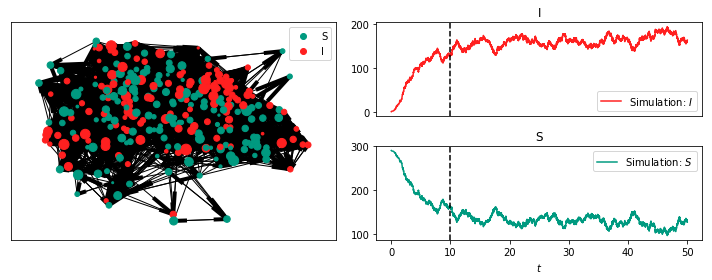

In [58]:
#Cite : From figure A.5 of Kiss, Miller, & Simon. Please cite the book if using this algorithm 
# --> Mathematics of Epidemics on Networks: from Exact to Approximate Models

gamma = 0.5
tau = 0.1

sim = EoN.fast_SIS(graph_attack, tau, gamma, tmax = 50,
                   initial_infecteds = 28, return_full_data=True)


sim.display(10,  node_size = [d[v]  for v in range(len(d))], IonTop= False, ts_plots=['I', 'S'], 
            pos = nx.spring_layout(graph_attack, k = 0.4))
plt.show()

# In order to get an .mp4 animation 
#ani=sim.animate(ts_plots=['I', 'S'],node_size = [d[v]  for v in range(len(d))], IonTop= False, pos = nx.spring_layout(graph_attack, k = 0.4))
#ani.save('SISAnimationAttack2.mp4', fps= 5, extra_args=['-vcodec', 'libx264'])




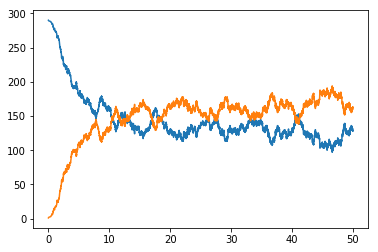

In [59]:
# Plotting Subsceptible (S) and Infected (I) evolution in time
plt.plot(sim.summary()[0],sim.summary()[1])
plt.plot(sim.summary()[0],sim.summary()[2])

In [60]:
#Subsceptible at 20 sec 
sim.summary()[1][2814]
#Infected at 20 sec 
sim.summary()[2][2814]

#check 
sim.summary()[1][2814]  +  sim.summary()[2][2814] == 291 

True

In [70]:
# I run 10000 simulations of the model (in order to have some stats) 
# from the weakened node, in order to understand if dynamics in affected in some way 

S_10sec = []
I_10sec = []

for i in xrange(0,10000):
    
        simprova = EoN.fast_SIS(graph_attack, tau, gamma, tmax = 15,
                   initial_infecteds = 28, return_full_data=True)
        
       # if lenght is >  1407 --> 1407 corresponds to time = 10 sec   
        if len(simprova.summary()[1]) > 1407: 
            S_10sec.append(simprova.summary()[1][1407])
            I_10sec.append(simprova.summary()[2][1407])
      # Else information flow doesn't exist --> the infection is exstinguished --> I = 0 
        else : 
            S_10sec.append(291)
            I_10sec.append(0)
    
   
    

In [71]:
print "Information flow exstinguishes in:", '%.2f' % (float(I_10sec.count(0))/float(len(I_10sec)) * 100),"% of the runs."

Il flusso di informazione si estingue nel: 46.05 % dei casi.


In [72]:
#  Complete network (before attack )

# I run 10000 simulations of the model (in order to have some stats) 
# from the same node (now the net is complete, before the attack), 
# in order to understand if dynamics in affected in some way 


S_10sec_sano = []
I_10sec_sano = []

for i in xrange(0,10000):
    
        simprova = EoN.fast_SIS(graph_ipsi_tresh, tau, gamma, tmax = 15,
                   initial_infecteds = 28, return_full_data=True)
        
       # if lenght is >  1407 --> 1407 corresponds to time = 10 sec  
        if len(simprova.summary()[1]) > 1407: 
            S_10sec_sano.append(simprova.summary()[1][1407])
            I_10sec_sano.append(simprova.summary()[2][1407])
       # Else information flow doesn't exist --> the infection is exstinguished --> I = 0
        else : 
            S_10sec_sano.append(291)
            I_10sec_sano.append(0)
    
   

In [73]:
print "Information flow exstinguishes in:", '%.2f' % (float(I_10sec_sano.count(0))/float(len(I_10sec_sano)) * 100), "% of the runs" 

Il flusso di informazione si estingue nel: 10.55 % dei casi


In [74]:
I_10sec[:] = (value for value in I_10sec if value != 0 )

In [75]:
I_10sec_sano[:] = (value for value in I_10sec_sano if value != 0 )

In [76]:
np.mean(I_10sec)

151.9191844300278

In [77]:
np.mean(I_10sec_sano)

152.27210732252655

## Node 188 (Pagerank) 
Red Nucleus (RN) --> Involved in gait 

In [213]:
# Getting sorted by weight connections from each node 
# and after that creating a new list with links that are going to be deleted
sorted_connections_node188 = sorted(connections_node188.items(), key=operator.itemgetter(1), reverse=True)

# It's possible to change the number of deleted links by setting a different number instead of 1.2 in --> 
# int(len(sorted_connections_node28)/1.2)
ebunch  = []
for i in xrange(0,int(len(sorted_connections_node188)/1.2)):
    ebunch.append((188, sorted_connections_node188[i][0]))

#ebunch 

In [214]:
# Creating the attacked graph as a copy of the original one
graph_attack188 = graph_ipsi_tresh.copy()
graph_attack188.remove_edges_from(ebunch)

In [215]:
# Let's take a look the outedges difference between the attacked and the former one 
graph_attack188.out_edges(188)

OutEdgeDataView([(188, 209), (188, 184), (188, 271)])

In [216]:
graph_ipsi_tresh.edges(188)

OutEdgeDataView([(188, 195), (188, 196), (188, 198), (188, 102), (188, 199), (188, 104), (188, 204), (188, 207), (188, 208), (188, 209), (188, 227), (188, 271), (188, 184), (188, 185), (188, 186), (188, 187), (188, 218)])

In [217]:
# Attacked Network 

# I run 10000 simulations of the model (in order to have some stats) 
# from the weakened node, in order to understand if dynamics in affected in some way 

S_10sec_188 = []
I_10sec_188 = []

for i in xrange(0,10000):
    
        simprova = EoN.fast_SIS(graph_attack188, tau, gamma, tmax = 15,
                   initial_infecteds = 188, return_full_data=True)
        
       # if lenght is >  1407 --> 1407 corresponds to time = 10 sec 
        if len(simprova.summary()[1]) > 1407: 
            S_10sec_188.append(simprova.summary()[1][1407])
            I_10sec_188.append(simprova.summary()[2][1407])
     # Else information flow doesn't exist --> the infection is exstinguished --> I = 0 
        else : 
            S_10sec_188.append(291)
            I_10sec_188.append(0)
            

In [218]:
print "Information flow exstinguishes in:", '%.2f' % (float(I_10sec_188.count(0))/float(len(I_10sec_188)) * 100),"% of the runs."

Il flusso di informazione si estingue nel: 91.18 % dei casi.


In [219]:
#  Complete network (before attack )

# I run 10000 simulations of the model (in order to have some stats) 
# from the same node (now the net is complete, before the attack), 
# in order to understand if dynamics in affected in some way 

S_10sec_sano_188 = []
I_10sec_sano_188 = []

for i in xrange(0,10000):
    
        simprova = EoN.fast_SIS(graph_ipsi_tresh, tau, gamma, tmax = 15,
                   initial_infecteds = 188, return_full_data=True)
        
       # if lenght is >  1407 --> 1407 corresponds to time = 10 sec 
        if len(simprova.summary()[1]) > 1407: 
            S_10sec_sano_188.append(simprova.summary()[1][1407])
            I_10sec_sano_188.append(simprova.summary()[2][1407])
     # Else information flow doesn't exist --> the infection is exstinguished --> I = 0
        else : 
            S_10sec_sano_188.append(291)
            I_10sec_sano_188.append(0)
    
   

In [220]:
print "Information flow exstinguishes in::", '%.2f' % (float(I_10sec_sano_188.count(0))/float(len(I_10sec_sano_188)) * 100), "% of the runs" 

Il flusso di informazione si estingue nel: 54.75 % dei casi


In [221]:
I_10sec_188[:] = (value for value in I_10sec_188 if value != 0 )

In [222]:
I_10sec_sano_188[:] = (value for value in I_10sec_sano_188 if value != 0 )

In [223]:
np.mean(I_10sec_188)

154.81405895691611

In [224]:
np.mean(I_10sec_sano_188)

153.84795580110497

## Node 169  (Highest degree)

In [227]:
# Getting sorted by weight connections from each node 
# and after that creating a new list with links that are going to be deleted
sorted_connections_node169 = sorted(connections_node169.items(), key=operator.itemgetter(1), reverse=True)

# It's possible to change the number of deleted links by setting a different number instead of 1.2 in --> 
# int(len(sorted_connections_node28)/1.2)
ebunch  = []
for i in xrange(0,int(len(sorted_connections_node169)/1.2)):
    ebunch.append((169, sorted_connections_node169[i][0]))


In [228]:
# Creating the attacked graph as a copy of the original one
graph_attack169 = graph_ipsi_tresh.copy()
graph_attack169.remove_edges_from(ebunch)

In [229]:
# Let's take a look the outedges difference between the attacked and the former one <<
graph_attack169.out_edges(169)

OutEdgeDataView([(169, 135), (169, 136), (169, 142), (169, 161), (169, 176), (169, 118)])

In [232]:
graph_ipsi_tresh.out_edges(169)

OutEdgeDataView([(169, 135), (169, 136), (169, 137), (169, 138), (169, 139), (169, 140), (169, 141), (169, 142), (169, 143), (169, 145), (169, 147), (169, 153), (169, 154), (169, 156), (169, 157), (169, 158), (169, 160), (169, 161), (169, 162), (169, 163), (169, 164), (169, 165), (169, 166), (169, 167), (169, 168), (169, 170), (169, 171), (169, 172), (169, 173), (169, 175), (169, 176), (169, 184), (169, 188), (169, 102), (169, 104), (169, 118)])

In [233]:
# Attacked Network 

# I run 10000 simulations of the model (in order to have some stats) 
# from the weakened node, in order to understand if dynamics in affected in some way 

S_10sec_169 = []
I_10sec_169 = []

for i in xrange(0,10000):
    
        simprova = EoN.fast_SIS(graph_attack169, tau, gamma, tmax = 15,
                   initial_infecteds = 169, return_full_data=True)
        
       # if lenght is >  1407 --> 1407 corresponds to time = 10 sec 
        if len(simprova.summary()[1]) > 1407: 
            S_10sec_169.append(simprova.summary()[1][1407])
            I_10sec_169.append(simprova.summary()[2][1407])
      # Else information flow doesn't exist --> the infection is exstinguished --> I = 0
        else : 
            S_10sec_169.append(291)
            I_10sec_169.append(0)
    

In [234]:
print "Information flow exstinguishes in:", '%.2f' % (float(I_10sec_169.count(0))/float(len(I_10sec_169)) * 100),"% of the runs."

Il flusso di informazione si estingue nel: 71.79 % dei casi.


In [235]:
#  Complete network (before attack )

# I run 10000 simulations of the model (in order to have some stats) 
# from the same node (now the net is complete, before the attack), 
# in order to understand if dynamics in affected in some way 

S_10sec_sano_169 = []
I_10sec_sano_169 = []

for i in xrange(0,10000):
    
        simprova = EoN.fast_SIS(graph_ipsi_tresh, tau, gamma, tmax = 15,
                   initial_infecteds = 169, return_full_data=True)
        
       # if lenght is >  1407 --> 1407 corresponds to time = 10 sec 
        if len(simprova.summary()[1]) > 1407: 
            S_10sec_sano_169.append(simprova.summary()[1][1407])
            I_10sec_sano_169.append(simprova.summary()[2][1407])
      # Else information flow doesn't exist --> the infection is exstinguished --> I = 0 
        else : 
            S_10sec_sano_169.append(291)
            I_10sec_sano_169.append(0)

In [236]:
print "Information flow exstinguishes in:", '%.2f' % (float(I_10sec_sano_169.count(0))/float(len(I_10sec_sano_169)) * 100), "% of the runs" 

Il flusso di informazione si estingue nel: 22.11 % dei casi


In [242]:
I_10sec_169[:] = (value for value in I_10sec_169 if value != 0 )

In [243]:
I_10sec_sano_169[:] = (value for value in I_10sec_sano_169 if value != 0 )

In [244]:
np.mean(I_10sec_169)

152.65437788018434

In [245]:
np.mean(I_10sec_sano_169)

151.78687893182695

In [251]:
# Attacked Network 

# I run 10000 simulations of the model (in order to have some stats) 
# from the weakened node, in order to understand if dynamics in affected in some way 

S_10sec_169_plus = []
I_10sec_169_plus = []


# (169, 135), (169, 136), (169, 142), (169, 161), (169, 176), (169, 118)
for i in xrange(0,10000):
    
        simprova = EoN.fast_SIS(graph_attack169, tau, gamma, tmax = 15,
                   initial_infecteds = (169, 135, 136, 142, 161, 176, 118) ,return_full_data=True)
        
       # if lenght is >  1407 --> 1407 corresponds to time = 10 sec   
        if len(simprova.summary()[1]) > 1407: 
            S_10sec_169_plus.append(simprova.summary()[1][1407])
            I_10sec_169_plus.append(simprova.summary()[2][1407])
      # Else information flow doesn't exist --> the infection is exstinguished --> I = 0
        else : 
            S_10sec_169_plus.append(291)
            I_10sec_169_plus.append(0) 

In [252]:
print "Information flow exstinguishes in:", '%.2f' % (float(I_10sec_169_plus.count(0))/float(len(I_10sec_169_plus)) * 100),"% of the runs."

Il flusso di informazione si estingue nel: 0.38 % dei casi.


In [253]:
#  Complete network (before attack )

# I run 10000 simulations of the model (in order to have some stats) 
# the infection starts from a set of nodes (now the net is complete, before the attack), 
# in order to understand if dynamics in affected in some way 

S_10sec_sano_169_plus = []
I_10sec_sano_169_plus = []

for i in xrange(0,10000):
    
        simprova = EoN.fast_SIS(graph_ipsi_tresh, tau, gamma, tmax = 15,
                   initial_infecteds = (169, 135, 136, 142, 161, 176, 118), return_full_data=True)
        
      # if lenght is >  1407 --> 1407 corresponds to time = 10 sec 
        if len(simprova.summary()[1]) > 1407: 
            S_10sec_sano_169_plus.append(simprova.summary()[1][1407])
            I_10sec_sano_169_plus.append(simprova.summary()[2][1407])
      # Else information flow doesn't exist --> the infection is exstinguished --> I = 0
        else : 
            S_10sec_sano_169_plus.append(291)
            I_10sec_sano_169_plus.append(0)
    

In [254]:
print "Information flow exstinguishes in:", '%.2f' % (float(I_10sec_sano_169_plus.count(0))/float(len(I_10sec_sano_169_plus)) * 100), "% of the runs" 

Il flusso di informazione si estingue nel: 0.27 % dei casi


In [255]:
I_10sec_169_plus[:] = (value for value in I_10sec_169_plus if value != 0 )

In [256]:
I_10sec_sano_169_plus[:] = (value for value in I_10sec_sano_169_plus if value != 0 )

In [257]:
np.mean(I_10sec_169_plus)

151.25195743826541

In [258]:
np.mean(I_10sec_sano_169_plus)

151.52892810588588

In [259]:
# Attacked Network 

# I run 10000 simulations of the model (in order to have some stats) 
# from the weakened node, in order to understand if dynamics in affected in some way 
S_10sec_169_plus1 = []
I_10sec_169_plus1 = []


# (169, 135), (169, 136), (169, 142), (169, 161), (169, 176), (169, 118)
for i in xrange(0,10000):
    
        simprova = EoN.fast_SIS(graph_attack169, tau, gamma, tmax = 15,
                   initial_infecteds = ( 135, 136, 142, 161, 176, 118) ,return_full_data=True)
        
       # if lenght is >  1407 --> 1407 corresponds to time = 10 sec 
        if len(simprova.summary()[1]) > 1407: 
            S_10sec_169_plus1.append(simprova.summary()[1][1407])
            I_10sec_169_plus1.append(simprova.summary()[2][1407])
      # Else information flow doesn't exist --> the infection is exstinguished --> I = 0
        else : 
            S_10sec_169_plus1.append(291)
            I_10sec_169_plus1.append(0) 

In [260]:
print "Information flow exstinguishes in:", '%.2f' % (float(I_10sec_169_plus1.count(0))/float(len(I_10sec_169_plus1)) * 100),"% of the runs."

Il flusso di informazione si estingue nel: 0.35 % dei casi.


In [261]:
# Complete Network (before attack )

# I run 10000 simulations of the model (in order to have some stats) 
# the infection starts from a set of nodes (now the net is complete, before the attack), 
# in order to understand if dynamics in affected in some way 

# Now without node 169 --> only neighbors are affected 
S_10sec_sano_169_plus1 = []
I_10sec_sano_169_plus1 = []

for i in xrange(0,10000):
    
        simprova = EoN.fast_SIS(graph_ipsi_tresh, tau, gamma, tmax = 15,
                   initial_infecteds = ( 135, 136, 142, 161, 176, 118), return_full_data=True)
        
       # if lenght is >  1407 --> 1407 corresponds to time = 10 sec 
        if len(simprova.summary()[1]) > 1407: 
            S_10sec_sano_169_plus1.append(simprova.summary()[1][1407])
            I_10sec_sano_169_plus1.append(simprova.summary()[2][1407])
      # Else information flow doesn't exist --> the infection is exstinguished --> I = 0 
        else : 
            S_10sec_sano_169_plus1.append(291)
            I_10sec_sano_169_plus1.append(0)
    

In [262]:
print "Information flow exstinguishes in:", '%.2f' % (float(I_10sec_sano_169_plus1.count(0))/float(len(I_10sec_sano_169_plus1)) * 100), "% of the runs" 

Il flusso di informazione si estingue nel: 0.41 % dei casi
